<a href="https://colab.research.google.com/github/CarolineP-DS/pyCOVID-demo/blob/master/notebooks/pyCOVID_Full_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><font size="15"><b>pyCOVID</b></font></center>

Machine learning classification project: detection of COVID-19+ vs normal vs viral pneumonies chest X-Rays based on [Kaggle dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database)<sup>1</sup>.


**Datapath:**

```bash
Google Drive
└───pyCOVID
    └───pyCOVID_data.7z       
```

```bash
Google Colab
└───data
    ├───COVID                            # 1200 files
    ├───NORMAL                           # 1341 files
    ├───Viral Pneumonia                  # 1345 files
    │
    ├─ COVID.metadata.xlsx
    ├─ NORMAL.metadata.xlsx
    └─ Viral Pneumonia.metadata.xlsx
```

<br>

---

<br>

1. : M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, M. T. Islam, “Can AI help in screening Viral and COVID-19 pneumonia?” IEEE Access, Vol. 8, 2020, pp. 132665 - 132676.

# Libraries

This notebook is best visualized in Google Colab with **dark mode enabled**.

In [ ]:
#@title
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import os

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers.convolutional import Conv2D , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils 
from keras.metrics import Recall

from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet201

from sklearn import metrics
from sklearn.model_selection import train_test_split

import itertools

import matplotlib.pyplot as plt
from matplotlib import cm

# set timezone
import time
os.environ['TZ'] = 'Europe/Paris'
time.tzset()

### Custom matplotlib Colab dark theme Caro
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "figure.figsize": [6,4.5],
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "#CDD2E9",
    "axes.facecolor": "#383838",
    "axes.edgecolor": "#899ab8",      
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "#546379",
    "figure.facecolor": "#383838",
    "figure.edgecolor": "#899ab8",
    "savefig.facecolor": "#383838",
    "savefig.edgecolor": "#899ab8"})

# Google Colab specific settings

After multiple stopovers, this project ended up being run on the Google Colab platform. Mainly to be able to easily use the GPU resources necessary to run our deep learning models.

We thus need to import data and check that the GPU activation is enabled. The compressed data file `pyCOVID_data.7z` is available at this [Google Drive link](https://drive.google.com/file/d/1BhkmEbVre8GJjNpPaYJWTiZx9POjs11C/view?usp=sharing) (~1.2Go).

1. Data folder has been uploaded to Google Drive. Leaving it there increases x30 computing time : we need to extract it to the local Colab kernel.
1. Google Colab enables GPU acceleration. It needs to be switched on in the `Runtime > Change Runtime type` menu.
  * We check if GPU is **activated and detectable** (output should be something like `"Found GPU at: /device:GPU:0"`).
  * If GPU acceleration is **not enabled**, then an error is raised and output is `"GPU device not found"`.<br><font color="ForestGreen">To resolve this, go to `Runtime > Change Runtime type` & select `GPU`.</font>

In [ ]:
### If "data" folder doesn't exist, then mount GDrive, extract data

import os
if os.path.isdir('./data'):
  print("Data is already on local disk, skipping importing step.")

else:
  ## Mount and access Google Drive
  from google.colab import drive
  drive.mount('/content/gdrive')

  ## Unzip pyCOVID_data.7z to local Colab disk
  !7z x "./gdrive/My Drive/pyCOVID/pyCOVID_data.7z"

Data is already on local disk, skipping importing step.


In [ ]:
### Check if GPU is being used
## print output should say : "Found GPU at: /device:GPU:0"
# if "GPU device not found", go to Runtime > Change Runtime type & select GPU

%tensorflow_version 2.x
import tensorflow as tf
gpu_name = tf.test.gpu_device_name()
if gpu_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(gpu_name))

Found GPU at: /device:GPU:0


# Preliminary exploration of dataset

* Metadata exploration:
    * Plots
    * Comparison of folder contents vs metadata: **one image missing in metadata**
* Data exploration:
    * Display of a random image from each type

## Exploratory data analysis

### Preprocessing of metadata

1. Define the base path for data files (`datapath`)
2. Read the 3 `*.metadata.xlsx` files provided for each type of chest X-Rays (`COVID`, `NORMAL` and `Viral Pneumonia`) and modify as needed to harmonize
3. Merge into single dataframe `meta`, arrange data as needed
4. Display first and last lines of `meta`

In [ ]:
# data root folder
# datapath = "../input/covid19-radiography-database/COVID-19 Radiography Database/"            # datapath on Kaggle
datapath = "./data/"                                                                         # Colab datapath

normal = pd.read_excel(datapath + "NORMAL.metadata.xlsx")
covid = pd.read_excel(datapath + "COVID.metadata.xlsx")
viral = pd.read_excel(datapath + "Viral Pneumonia.metadata.xlsx")

# harmonize covid.FILE NAME nomenclature
covid["FILE NAME"] = covid["FILE NAME"].str.replace("COVID", "COVID-")

# merge all
meta = pd.concat([normal, covid, viral], axis=0)

## create "type" and "n_img" cols
# split string at first "-" into 2 cols
meta[["type", "n_img"]] = meta["FILE NAME"].str.split("-", n = 1, expand = True)
meta["n_img"] = meta["n_img"].astype("int")
meta = meta.reindex(columns=["type", "n_img", "FORMAT", "SIZE", "URL", "FILE NAME"])       # reorder cols

meta.columns = ["type", "n_img", "format", "size", "source_url", "filename"]            # rename cols

# meta["type"].unique()    # check content of `type` col
# meta.info()

meta

type  ...              filename
0              NORMAL  ...              NORMAL-1
1              NORMAL  ...              NORMAL-2
2              NORMAL  ...              NORMAL-3
3              NORMAL  ...              NORMAL-4
4              NORMAL  ...              NORMAL-5
...               ...  ...                   ...
1340  Viral Pneumonia  ...  Viral Pneumonia-1341
1341  Viral Pneumonia  ...  Viral Pneumonia-1342
1342  Viral Pneumonia  ...  Viral Pneumonia-1343
1343  Viral Pneumonia  ...  Viral Pneumonia-1344
1344  Viral Pneumonia  ...  Viral Pneumonia-1345

[3885 rows x 6 columns]

### Contents of dataset

* Dataset contains 3 types of patient lung diagnosis: `COVID`, `NORMAL` and `Viral Pneumonia`.
* 3885 images total
* All images are in `.PNG` format
* 2 types of sizes:
    - `1024 x 1024px`
    - `256 x 256px`
* `256 x 256px` are all the `COVID` images

In [ ]:
#@title
print("Count of unique sizes present in dataset:")
print(meta["size"].value_counts(), "\n\n")

print("meta.describe():")
meta.drop(columns="n_img").describe()

Count of unique sizes present in dataset:
1024*1024    2686
256*256      1199
Name: size, dtype: int64 


meta.describe():


type  ...    filename
count              3885  ...        3885
unique                3  ...        3885
top     Viral Pneumonia  ...  NORMAL-369
freq               1345  ...           1

[4 rows x 5 columns]

In [ ]:
#@title
print('meta[meta["size"] == "256*256"]["type"].unique()')
meta[meta["size"] == "256*256"]["type"].unique()

meta[meta["size"] == "256*256"]["type"].unique()


array(['COVID'], dtype=object)

<a name="barplot"></a>
### Pie chart

The three classes are pretty balanced, each representing ~1/3 of the dataset.

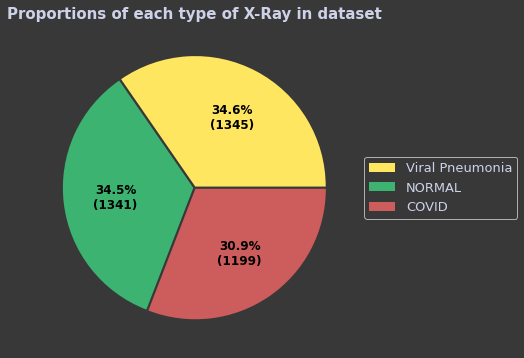

In [ ]:
#@title
### Custom matplotlib Colab dark theme Caro
# plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "figure.figsize": [6,4.5],
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "#CDD2E9",
    "axes.facecolor": "#383838",
    "axes.edgecolor": "#899ab8",      
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "#546379",
    "figure.facecolor": "#383838",
    "figure.edgecolor": "#899ab8",
    "savefig.facecolor": "#383838",
    "savefig.edgecolor": "#899ab8"})

## counts
tot = meta["type"].value_counts()

## Pie chart (cf https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py)
fig, ax = plt.subplots(figsize=(12, 6))

# colors
colors = ["#ffe660",
          "mediumseagreen",
          "indianred"]

def func(pct, allvals):
    absolute = int(round(pct/100.*np.sum(allvals)))      # added round() to prevent rounding errors
    return "{:.1f}%\n({:d})".format(pct, absolute)




wedges, texts, autotexts = ax.pie(tot, autopct=lambda pct: func(pct, tot),
                                  textprops=dict(color="black"),
                                  colors=colors, 
                                  explode=(0.01, 0.01, 0.01))

ax.legend(wedges, tot.index,
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1),
         fontsize = 13)

plt.setp(autotexts, size=12, weight="bold")

ax.set_title("Proportions of each type of X-Ray in dataset", 
             fontdict={'fontsize': 15, 
                       'fontweight': 'bold'});

<a name="missing"></a>
## Actual number of images in folders

One COVID image present in COVID subfolder is **missing** from the metadata file: `COVID (1200).png`

In [ ]:
#@title
print("Number of files within each subfolder:\n")

types = ["Viral Pneumonia", "NORMAL", "COVID"]

import os.path
for t in ts:
    num_files = len([f for f in os.listdir(datapath + t + "/")if os.path.isfile(os.path.join(datapath + t + "/", f))])
    print("%s folder has\t\t %s files" % (t, num_files))
    
print("\n\nFile counts of metadata files:\n")
print(tot)

Number of files within each subfolder:

Viral Pneumonia folder has		 1345 files
NORMAL folder has		 1341 files
COVID folder has		 1200 files


File counts of metadata files:

Viral Pneumonia    1345
NORMAL             1341
COVID              1199
Name: type, dtype: int64


In [ ]:
#@title
## natural sorting
from natsort import natsorted

print("Last 5 images contained in COVID subfolder, with filenames natural sorted:")
print(natsorted(os.listdir(datapath + types[2] + "/"))[-5:])        # print last 5 images contained in COVID subfolder, natural sorted

print("\n\nLast 5 images contained in COVID metadata, with filenames natural sorted:")
natsorted(covid["FILE NAME"])[-5:]                           # print last 5 images listed in COVID metadata, natural sorted

Last 5 images contained in COVID subfolder, with filenames natural sorted:
['COVID (1196).png', 'COVID (1197).png', 'COVID (1198).png', 'COVID (1199).png', 'COVID (1200).png']


Last 5 images contained in COVID metadata, with filenames natural sorted:


['COVID- 1195', 'COVID- 1196', 'COVID- 1197', 'COVID- 1198', 'COVID- 1199']

<a name="imgex"></a>
## Image examples from dataset

Resize all images to the smallest size in dataset: 256 x 256 pixels (COVID images).

Randomly select a number within the range of the smallest dataset (here COVID), and show the images corresponding to that number in each of the three datasets

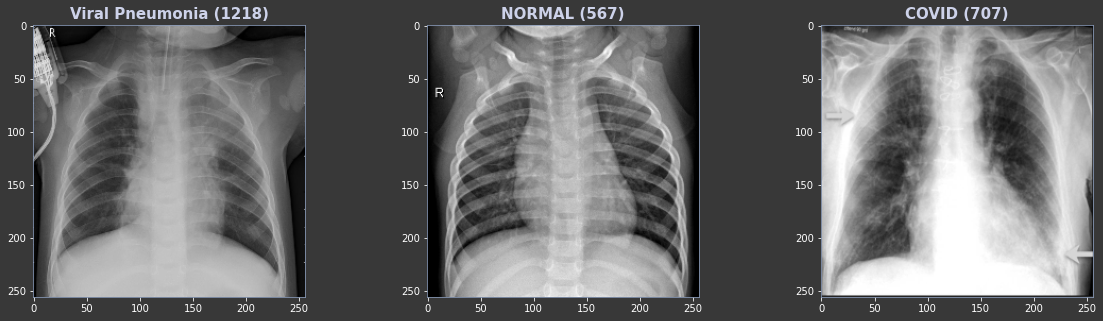

In [ ]:
#@title
#### Display a random image for each type
import os.path

types = ["Viral Pneumonia", "NORMAL", "COVID"]
num_files = {}   # number of files in each folder/type
rand_n = {}      # store random number for each type
img_paths = []   # filepaths to selected random img
imgs = []        # corresponding img arrays

for t in types:
    # number of files in each folder/type
    num_files[t] = len([f for f in os.listdir(datapath + t + "/")if os.path.isfile(os.path.join(datapath + t + "/", f))])
    
    # choose random file number within range of each t and generate filepath
    rand_n[t] = str(np.random.randint(1, num_files[t], 1)[0])
    img_paths.append(datapath + t + "/" + t + " (" + rand_n[t] + ").png")

# read imgs in list
for i in img_paths:
    orig = cv2.imread(i, cv2.IMREAD_GRAYSCALE)     # read img
    resized = cv2.resize(orig, dsize= (256,256))   # resize it to 256 x 256
    imgs.append(resized)

# display images
fig = plt.figure(figsize=(20, 5))

for i, t in zip(range(3), types):
    ax = fig.add_subplot(131 + i)
    ax.imshow(imgs[i], cmap="gray")
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
#     plt.xticks([])
#     plt.yticks([])

# Visualisation: feature detection & description

### Contents:

* [Image examples](#imgex) from dataset
* [Thresholding](#seuil)
    * Binary thresholding
    * Adaptive thresholding
* [Edge detection](#bords)
    * Edge detection alone
    * Gaussian blur + edge detection
    * Adaptive thresholding + edge detection
    * Gaussian blur + adaptive thresholding + edge detection
* [Differences in contrast between types](#contrast)

<a name="seuil"></a>
## Thresholding

1. Thresholding
1. Adaptive thresholding


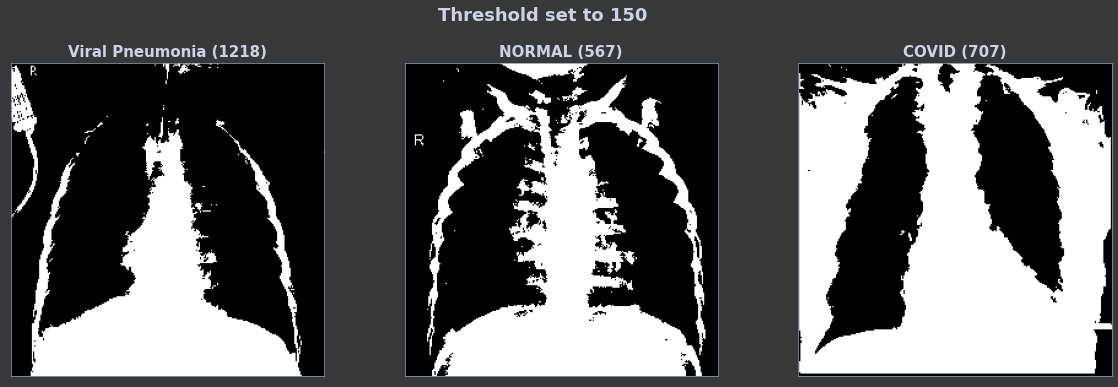

In [ ]:
#@title
################# seuillages

thresh = []        # store thresholded imgs
fig = plt.figure(figsize=(20, 6))

##### Set threshold here #####
seuil = 150
##############################

fig.suptitle('Threshold set to %s' %seuil, fontsize=18, fontweight="bold", y = 0.98)    # position suptitle (must be <1)
fig.subplots_adjust(top=0.85)         # fix max height of subplots to leave space between suptitle and subplots

for i, t in zip(range(3), types):
    # thresholding
    seuil, img_seuillage = cv2.threshold(imgs[i], seuil, 255, t = cv2.THRESH_BINARY)  # if pixel intensity > 115 then pixel set to 255 (white), else to 0 (black)
    thresh.append(img_seuillage)
    
    # display images
    ax = fig.add_subplot(131 + i)
    ax.imshow(thresh[i], cmap="gray")
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
    plt.xticks([])
    plt.yticks([]);

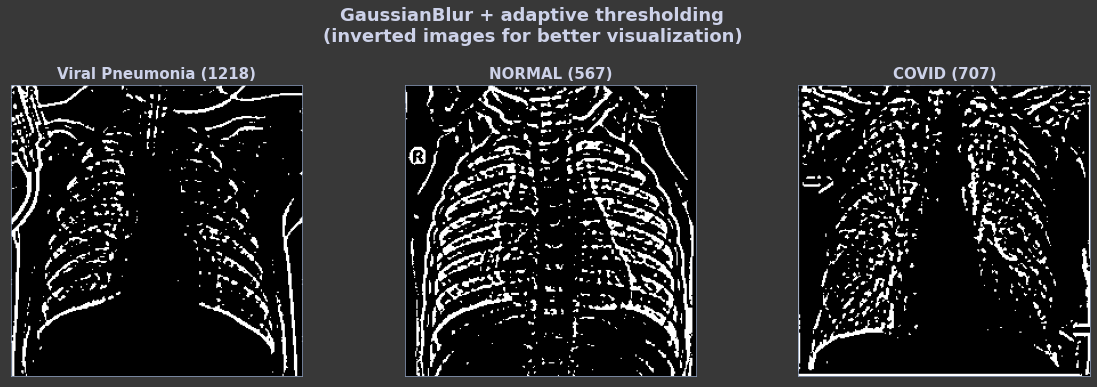

In [ ]:
#@title
############## GaussianBlur + adaptive threshold
adap = []        # store thresholded imgs
gauss = []       # store GaussianBlur filters

fig = plt.figure(figsize=(20, 6))

fig.suptitle('GaussianBlur + adaptive thresholding\n(inverted images for better visualization)', fontsize=18, fontweight="bold", y = 0.98)    # position suptitle (must be <1)
fig.subplots_adjust(top=0.8)         # fix max height of subplots to leave space between suptitle and subplots

for i, t in zip(range(3), types):
    # GaussianBlur
    gauss.append(cv2.GaussianBlur(imgs[i], ksize = (3,3), sigmaX = 0))
    
    # thresholding
    img_seuillage_2 = cv2.adaptiveThreshold(gauss[i], 255, 
                                            adaptiveMethod  = cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            thresholdType = cv2.THRESH_BINARY,
                                            blockSize = 11,
                                            C = 5)

    adap.append(img_seuillage_2)
    
    # display images
    ax = fig.add_subplot(131 + i)
    ax.imshow(cv2.bitwise_not(adap[i]), cmap="gray")             # negative image for better visualization
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
    plt.xticks([])
    plt.yticks([]);

<a name="bords"></a>
## Edge detection : `Canny`

1. Edge detection alone
1. Gaussian blur + edge detection
1. Adaptive thresholding + edge detection
1. Gaussian blur + adaptive thresholding + edge detection

We tried to combine adaptive thresholding with edge detection before realizing that there was no point in doing so: having a binary image defeats the whole purpose of `Canny`. And indeed, those images (3 & 4) are hard to make sense of.



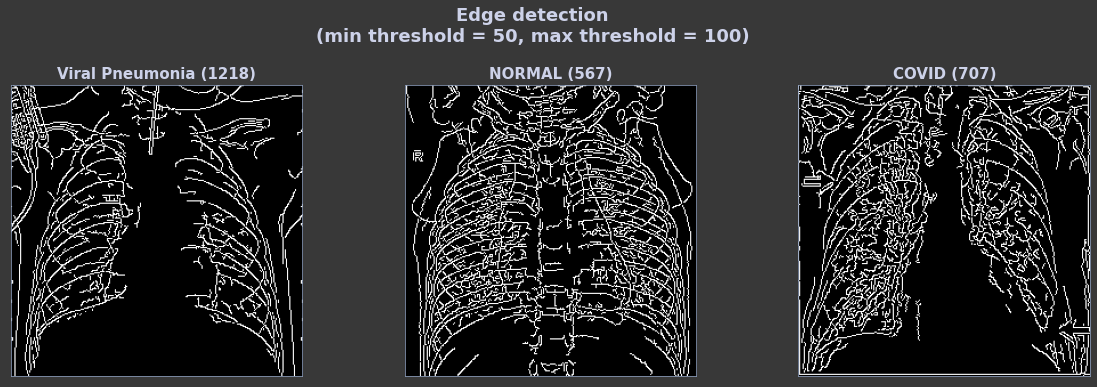

In [ ]:
#@title
############## Canny alone
edges_0 = []        # store imgs

##### Set thresholds here #####
t_min = 50      # min threshold
t_max = 100     # max threshold
###############################

fig = plt.figure(figsize=(20, 6))

fig.suptitle('Edge detection\n(min threshold = %s, max threshold = %s)' %(t_min, t_max), fontsize=18, fontweight="bold", y = 0.98)    # position suptitle (must be <1)
fig.subplots_adjust(top=0.8)         # fix max height of subplots to leave space between suptitle and subplots

for i, t in zip(range(3), types):    
    
    # edge detection
    edges_0.append(cv2.Canny(imgs[i], t_min, t_max))
    
    # display images
    ax = fig.add_subplot(131 + i)
    ax.imshow(edges_0[i], cmap="gray")
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
    plt.xticks([])
    plt.yticks([]);

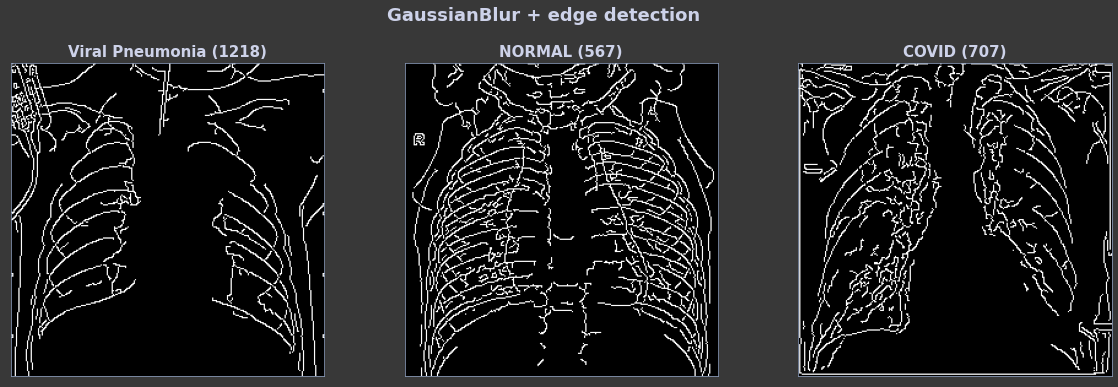

In [ ]:
#@title
############## GaussianBlur + Canny
edges_1 = []        # store thresholded imgs

fig = plt.figure(figsize=(20, 6))

fig.suptitle('GaussianBlur + edge detection', fontsize=18, fontweight="bold", y = 0.98)    # position suptitle (must be <1)
fig.subplots_adjust(top=0.85)         # fix max height of subplots to leave space between suptitle and subplots

for i, t in zip(range(3), types):    
    
    # edge detection on GaussianBlurred imgs
    edges_1.append(cv2.Canny(gauss[i], t_min, t_max))
    
    # display images
    ax = fig.add_subplot(131 + i)
    ax.imshow(edges_1[i], cmap="gray")
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
    plt.xticks([])
    plt.yticks([]);

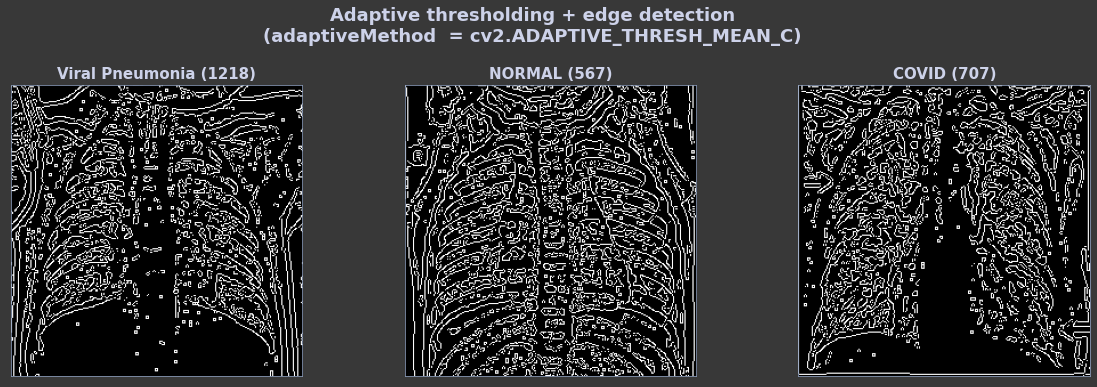

In [ ]:
#@title
############## Adaptive threshold + Canny
adap_meanC = []     # store thresholded imgs
edges_2 = []        # store imgs

fig = plt.figure(figsize=(20, 6))

fig.suptitle('Adaptive thresholding + edge detection\n(adaptiveMethod  = cv2.ADAPTIVE_THRESH_MEAN_C)', fontsize=18, fontweight="bold", y = 0.98)    # position suptitle (must be <1)
fig.subplots_adjust(top=0.80)         # fix max height of subplots to leave space between suptitle and subplots

for i, t in zip(range(3), types):
    
    # thresholding
    adap_meanC.append(cv2.adaptiveThreshold(imgs[i], 255, 
                                            adaptiveMethod  = cv2.ADAPTIVE_THRESH_MEAN_C, 
                                            thresholdType = cv2.THRESH_BINARY,
                                            blockSize = 11,
                                            C = 5))
    
    
    # edge detection
    edges_2.append(cv2.Canny(adap_meanC[i], t_min, t_max))
    
    # display images
    ax = fig.add_subplot(131 + i)
    ax.imshow(edges_2[i], cmap="gray")
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
    plt.xticks([])
    plt.yticks([]);

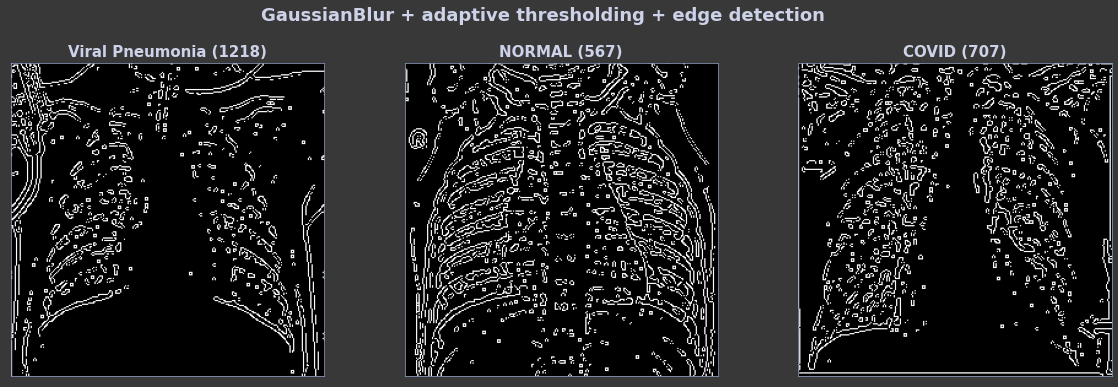

In [ ]:
#@title
############## GaussianBlur + adaptive threshold + Canny
edges = []        # store thresholded imgs

fig = plt.figure(figsize=(20, 6))

fig.suptitle('GaussianBlur + adaptive thresholding + edge detection', fontsize=18, fontweight="bold", y = 0.98)    # position suptitle (must be <1)
fig.subplots_adjust(top=0.85)         # fix max height of subplots to leave space between suptitle and subplots

for i, t in zip(range(3), types):    
    
    # edge detection
    edges.append(cv2.Canny(adap[i], t_min, t_max))
    
    # display images
    ax = fig.add_subplot(131 + i)
    ax.imshow(edges[i], cmap="gray")
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
    plt.xticks([])
    plt.yticks([]);

## Finding relevant lines: `HoughLinesP`

This does not seem very relevant here...

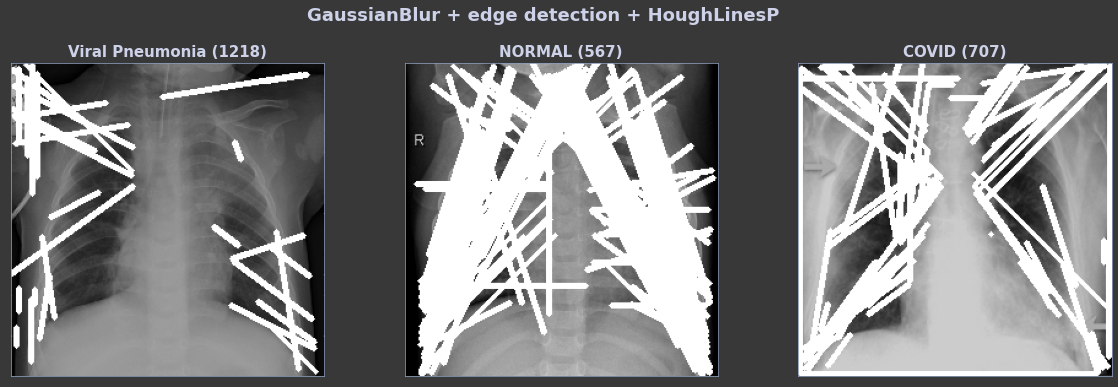

In [ ]:
#@title
############## GaussianBlur + Canny + HoughLinesP
lines = []        # store lines
line_imgs = []   # store lines as imgs
combo = []        # store overlaid imgs

fig = plt.figure(figsize=(20, 6))

fig.suptitle('GaussianBlur + edge detection + HoughLinesP', fontsize=18, fontweight="bold", y = 0.98)    # position suptitle (must be <1)
fig.subplots_adjust(top=0.85)         # fix max height of subplots to leave space between suptitle and subplots

for i, t in zip(range(3), types):    
    
    # find relevant lines
    lines.append(cv2.HoughLinesP(edges_1[i],
                                 rho=3,
                                 theta=np.pi / 20,
                                 threshold=100,
                                 minLineLength=0,
                                 maxLineGap= 20))
    
    # create img of lines
    line_imgs.append(np.zeros_like(imgs[i]))
    
    for line in lines[i]:
        for x1, y1, x2, y2 in line:
            cv2.line(line_imgs[i], (x1, y1), (x2, y2), color = [255, 0, 0], thickness=3)
            
    combo.append(cv2.addWeighted(imgs[i], 0.8, line_imgs[i], 1.0, 0.0))
    
    # display images
    ax = fig.add_subplot(131 + i)
    ax.imshow(combo[i], cmap="gray")
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
    plt.xticks([])
    plt.yticks([]);

<a name="contrast"></a>
## Differences in contrast between types

We counted the intensity values taken by all the pixels of all the images for a given type. We can see here that there are much more 0 values (black pixels) in the _normal_ X-rays than in the _viral pneumonia_ X-rays than in the _COVID-19_ X-rays. Distributions seem to be very close. However, it can be noticed that the distribution of _COVID-19_ is slightly shifted toward the brighter values compared to the _normal_, while the _viral pneumonia_ seems to be mostly shifted toward the mid-high values (150-200).

This correlates with the differences in contrast we have observed between the three classes while generating multiple random sets: _normal_ X-rays have, in general, empty/black lungs, while _COVID-19_ and _viral pneumonia_ X-rays have, in general, more opaque/white lungs, indicative of the fluid and debris filling the lungs.

In [ ]:
#@title
############################ /!\ LONG

###### read all images in each of 3 folders
import os

def load_images_from_folder(folder):
    """
    Load all files from given folder, in grayscale, resize in 256x256
    """
    images = []
    for filename in os.listdir(folder):        
        img = cv2.resize(cv2.imread(os.path.join(folder,filename), cv2.IMREAD_GRAYSCALE), dsize= (256,256))   # resize it to 256 x 256
        if img is not None:
            images.append(img)
    return images

all_img = {}   # dictionary of 3 lists each containing 1200+ arrays of imgs
flat = {}     # dictionary of 3 mega arrays

for t in types:
    # load all images
    all_img[t] = load_images_from_folder(datapath + t + "/")    ############################ /!\ LONG
    # merge all arrays for each folder
    flat[t] = np.vstack(all_img[t]).flatten()    ### quick


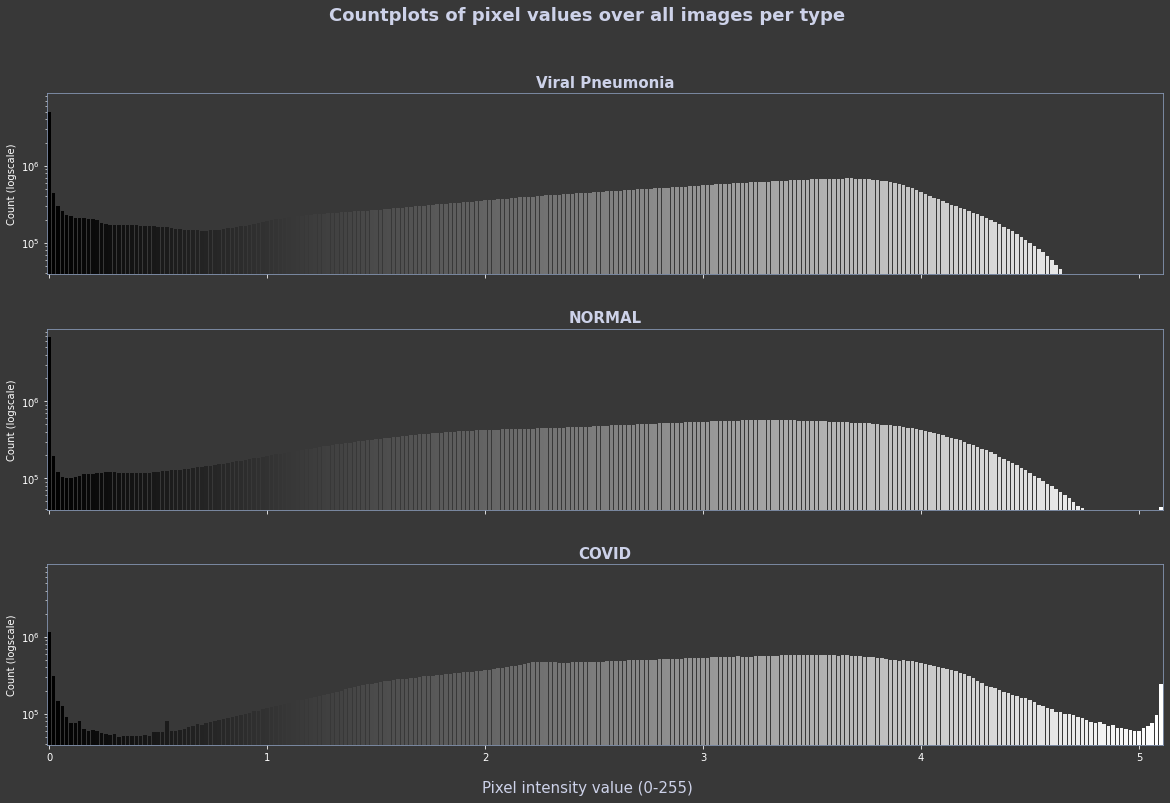

In [ ]:
#@title
######################################################## /!\ LONG

### custom palette grayscale over all 256 values (0 to 255)
colors = []
for i in range(256):    
    colors.append([i/255, i/255, i/255])
customPalette = sns.set_palette(sns.color_palette(colors))

########## PLOT
fig, axes = plt.subplots(figsize=(20,12), sharex=True, sharey=True, nrows = 3)
fig.subplots_adjust(hspace=0.3)         # space images / hspace = fraction of axis height

fig.suptitle('Countplots of pixel values over all images per type', fontsize=18, fontweight="bold")

fig.text(0.5, 0.07, "Pixel intensity value (0-255)", ha='center', fontdict={'fontsize': 15})

for i, t, ax in zip(range(3), types, axes):

    plot = sns.countplot(x=flat[t], palette = customPalette, ax=ax)
    plot.set_title(t, fontdict={'fontsize': 15, 
                                'fontweight': 'bold'})
    plot.set_yscale("log")
    plot.set_ylabel("Count (logscale)")
    ax.set_xticks(np.arange(0, 256, 50))

## Conclusion

None of the visualization techniques we tried could help us easily classify X-rays. From one random set of images to the next, the results vary greatly. Sometimes the normal X-ray is the one with the clearer contrast between lungs and ribs and as such with the better edge detection of the ribs (which is intuitively what we expect), but this is absolutely not consistent.

An interesting approach would be to add [lung segmentation](https://bmcmedimaging.biomedcentral.com/articles/10.1186/s12880-020-00514-y#availability-of-data-and-materials) to our model. At this moment, we lacked time and expertise to implement it in our visualization step.

# Modelisation : building a model from scratch

We focus here on creating, evaluating and optimizing a simple deep learning CNN model that will be able to

1. **extract features** from the chest X-rays we feed as input, with its convolutional part,
1. **classify** images based on those features with its fully connected layers (dense layers).

<img src="https://miro.medium.com/max/1000/1*vkQ0hXDaQv57sALXAJquxA.jpeg">
<center><font size="2">From <a href=https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53>A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way</a>, by Sumit Saha</font></center>

## Create a dataframe with filepaths and classes

Since the metadata files were missing a file for the COVID type, we re-listed ourselves the files contained in each of the three folders and assigned labels and class numbers accordingly.

<br>

---

<br>

<font color="IndianRed">**ONE-HOT ENCODING:** one-hot encoded the three classes, in order to not use the `sparse_categorical_crossentropy` loss function but the `categorical_crossentropy` and thus be able to use binary metrics such as Precision or Recall.</font>

In [ ]:
#@title
#### Get all filepaths and corresponding folder==class

# data root folder
# datapath = "data/"    # Caro local
# datapath = "/content/gdrive/My Drive/pyCOVID/data/"   # Google Colab mounted Google Drive
datapath = "./data/"    # Google Colab local

types = ["Viral Pneumonia", "NORMAL", "COVID"]
files = []       # filepaths of all image for each folder/type

for t in types:
    # list of filepaths in each folder/type
    files.append([datapath + t + "/" + f for f in os.listdir(datapath + t + "/")if os.path.isfile(os.path.join(datapath + t + "/", f))])
    
# flatten the list of 3 sublists
files = [item for sublist in files for item in sublist]

# turn into a naturally sorted DF
df = pd.DataFrame(natsorted(files), columns=["filepaths"])

# add labels
df["label"] = np.where(df.filepaths.str.contains("Viral Pneumonia"), "ViralPneumonia",
                       np.where(df.filepaths.str.contains("NORMAL"), "Normal", "COVID"))

onehot = pd.get_dummies(df["label"])

df = pd.concat([df, onehot], axis=1)

df["class"] = np.where(df.filepaths.str.contains("Viral Pneumonia"), "2",
                       np.where(df.filepaths.str.contains("NORMAL"), "0", "1"))

df = df[["filepaths", "label", "class", "Normal", "COVID", "ViralPneumonia"]]

print("Number of files per type:")
print(df["label"].value_counts())
print("\nLabels and classes:")
print("Normal\t\t= 0\nCOVID\t\t= 1\nViral Pneumonia\t= 2")

df.head(10)

Number of files per type:
ViralPneumonia    1345
Normal            1341
COVID             1200
Name: label, dtype: int64

Labels and classes:
Normal		= 0
COVID		= 1
Viral Pneumonia	= 2


filepaths  label class  Normal  COVID  ViralPneumonia
0   ./data/COVID/COVID (1).png  COVID     1       0      1               0
1   ./data/COVID/COVID (2).png  COVID     1       0      1               0
2   ./data/COVID/COVID (3).png  COVID     1       0      1               0
3   ./data/COVID/COVID (4).png  COVID     1       0      1               0
4   ./data/COVID/COVID (5).png  COVID     1       0      1               0
5   ./data/COVID/COVID (6).png  COVID     1       0      1               0
6   ./data/COVID/COVID (7).png  COVID     1       0      1               0
7   ./data/COVID/COVID (8).png  COVID     1       0      1               0
8   ./data/COVID/COVID (9).png  COVID     1       0      1               0
9  ./data/COVID/COVID (10).png  COVID     1       0      1               0

## Split data: training / test
We split the data with the training set representing 80% of the complete dataset, and the testing set representing the remaining 20%, in a stratified manner in order to preserve the balance of classes in the train & test sets.

In [ ]:
data_train, data_test = train_test_split(df, 
                                         test_size=0.2, 
                                         stratify=df["class"], 
                                         random_state=123)

print("Normalized count values of classes in datasets:\n")

print("Original df:\n%s" % df["class"].value_counts(normalize=True))

print("\nTrain set:\n%s" % data_train["class"].value_counts(normalize=True))
print("\nTest set:\n%s" % data_test["class"].value_counts(normalize=True))

Normalized count values of classes in datasets:

Original df:
2    0.346114
0    0.345085
1    0.308801
Name: class, dtype: float64

Train set:
2    0.346203
0    0.344916
1    0.308880
Name: class, dtype: float64

Test set:
2    0.345758
0    0.345758
1    0.308483
Name: class, dtype: float64


## Image generator

We'll be implementing several transformations on the training dataset :

* rotation
* horizontal/vertical shift
* ~brightness~
* ~zoom~
* horizontal/vertical flip

<br>

---

<br>

<font color="IndianRed">**UPDATE:** zoom and brightness transformations were removed as they could impair the accuracy of the model. Brightness should not be modified as the X-rays are optimally captured by the radiologist, and could impact detection of features based on contrast. Zoom could negatively impact feature detection if for instance the lungs' edges are not on the image.<br>
**IMPORTANT:** `shuffle=False` has been added to the `test_data_generator.flow_from_dataframe`: default is `True` and messes up the confusion matrix. Predictions on shuffled `test_set` can't be compared to the non-shuffled real values of the original dataframe and gives bad metrics.

**ONE-HOT ENCODING:** modified `y_col=["class"]` and `class_mode="sparse"` (cf [here](https://stackoverflow.com/a/60666658/8876619))</font>

<br>

---

<br>

<font color="Teal">**Technical note:** Pandas `SettingWithCopyWarning` were suppressed for this cell only.</font>

In [ ]:
### Image generator
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          rotation_range=10,
                                          width_shift_range=.1,
                                          height_shift_range=.1,
                                          # zoom_range=.1,
                                          # brightness_range=[0.2,1.0],
                                          horizontal_flip=True,
                                          vertical_flip=True)

test_data_generator = ImageDataGenerator(rescale = 1./255)

### Iterator
batch_size = 16
n_class = len(df["class"].unique())

# pour éviter l'erreur If class_mode="sparse", y_col="class" column values must be strings.
# il faut convertir data["class"] en str()

pd.options.mode.chained_assignment = None   # suppress Pandas SettingWithCopyWarning
data_train["class"] = data_train["class"].astype(str)
data_test["class"] = data_test["class"].astype(str)
pd.options.mode.chained_assignment = "warn"   # set default back

training_set = train_data_generator.flow_from_dataframe(dataframe=data_train,      # df contenant les infos
                                                        x_col="filepaths",         # col du df contenant les filepaths
                                                        y_col=["Normal", "COVID", "ViralPneumonia"],             # cols du df contenant les one hot encoded classes
                                                        class_mode="raw",       # pour prendre les 4 colonnes
                                                        target_size=(224,224),     # taille des images à redimensionner
                                                         color_mode="grayscale",    # images en n&b                                                        
                                                        batch_size=batch_size)

test_set = test_data_generator.flow_from_dataframe(dataframe=data_test,         # df contenant les infos
                                                   x_col="filepaths",           # col du df contenant les filepaths
                                                   y_col=["Normal", "COVID", "ViralPneumonia"],             # cols du df contenant les one hot encoded classes
                                                   class_mode="raw",         # pour prendre les 4 colonnes
                                                   target_size=(224,224),       # taille des images à redimensionner
                                                   color_mode="grayscale",    # images en n&b
                                                   shuffle = False,             # nécessaire pour que les prédictions soient dans le même ordre que les vraies valeurs
                                                   batch_size=batch_size)

Found 3108 validated image filenames.
Found 778 validated image filenames.


## Network design

We design a simple CNN model with 2 convolution layers and 3 dense layers. The detailed and commented description is provided in the code section.

In [ ]:
## instanciation du modèle
classifier = Sequential()

## construction des 7 couches
conv1 = Conv2D(filters = 64,                 # couche composée de 64 matrices de convolution
                  input_shape = (224, 224, 1),  # l'image passée en entrée a 224 pixels de hauteur, 224 pixels de largeur et 1 canaux Garyscale
                  kernel_size = (3, 3),         # noyau de convolution de dimension 3x3 (9 neurones par filtre)
                  padding = "valid",            # pour que le noyau ne puisse pas dépasser les bords de l'image
                  activation = "relu")

maxpool = MaxPooling2D(pool_size = (2, 2))    # le maximum sera calculé sur des tuiles de dimensions 2x2

batchNorm = BatchNormalization()              # The layer will transform inputs so that they are standardized: mean = 0 and standard deviation = 1

conv2 = Conv2D(filters = 64,                 # couche composée de 64 matrices de convolution
                  kernel_size = (3, 3),         # noyau de convolution de dimension 3x3 (9 neurones par filtre)
                  padding = "valid",            # pour que le noyau ne puisse pas dépasser les bords de l'image
                  activation = "relu")

maxpool = MaxPooling2D(pool_size = (2, 2))    # test

dropout = Dropout(rate=0.2)                  # test

flatten = Flatten()                          # pour transformer les matrices en vecteurs à donner en input à des couches denses

dense_1 = Dense(units = 1024,                  # nombre de neurones
                activation ='relu')           # fonction d'activation

dropout = Dropout(rate=0.2)

dense_2 = Dense(units = 512,                  # nombre de neurones
                activation ='relu')           # fonction d'activation

dense_3 = Dense(units = n_class,                   # output layer
                activation ='softmax')        # fonction d'activation

## ajout des couches au modèle
classifier.add(conv1)
classifier.add(maxpool)
classifier.add(batchNorm)
classifier.add(conv2)
classifier.add(maxpool)
# classifier.add(batchNorm)
classifier.add(dropout)
classifier.add(flatten)
classifier.add(dense_1)
classifier.add(dropout)
classifier.add(dense_2)
classifier.add(dropout)
classifier.add(dense_3)

### Adding metrics

One of the most relevant metric to this project is the **recall** because we absolutely do not want to misdiagnose true COVID patients as falsely healthy or with a "simple" viral pneumonia. As that would mean that true COVID cases would slip through the specific medical care, quarantine protocols etc, and would propagate the disease. On the contrary, we are willing to misdiagnose true healthy or viral pneumonia patients as false COVID, "better safe than sorry". 

Here we compile the model and create recall metrics for **each class**.

In [ ]:
## compilation
classifier.compile(optimizer = "adam", 
                   loss = "categorical_crossentropy", 
                   metrics = ["accuracy", 
                              Recall(class_id=0, name="recall_norm"),      # recall of Normal class
                              Recall(class_id=1, name="recall_COV"),       # recall of COVID class
                              Recall(class_id=2, name="recall_VP")])       # recall of Viral Pneumonia class
                  

### Fitting

We train the model on only 5 epochs, to get a sense of its basic accuracy.

<br>

---

<br>

<font color="Teal">**Technical note:** `classifier.fit_generator` is deprecated in this version and was updated with `classifier.fit`.</font>

In [ ]:
epochs = 5

## training
history = classifier.fit(training_set,    # previously generator=training_set
                         epochs=epochs, 
                         steps_per_epoch=len(data_train) // batch_size, 
                         workers = -1, 
                         validation_data=test_set, 
                         validation_steps=len(data_test) // batch_size)

Epoch 1/5
194/194 [==============================] - 73s 363ms/step - loss: 9.0954 - accuracy: 0.6278 - recall_norm: 0.5855 - recall_COV: 0.6488 - recall_VP: 0.5706 - val_loss: 1.1044 - val_accuracy: 0.3112 - val_recall_norm: 0.0000e+00 - val_recall_COV: 0.0000e+00 - val_recall_VP: 0.0000e+00
Epoch 2/5
194/194 [==============================] - 67s 344ms/step - loss: 0.4477 - accuracy: 0.8342 - recall_norm: 0.8510 - recall_COV: 0.8587 - recall_VP: 0.7589 - val_loss: 1.0645 - val_accuracy: 0.3633 - val_recall_norm: 0.0000e+00 - val_recall_COV: 0.3975 - val_recall_VP: 0.0377
Epoch 3/5
194/194 [==============================] - 67s 343ms/step - loss: 0.3454 - accuracy: 0.8865 - recall_norm: 0.8885 - recall_COV: 0.9102 - recall_VP: 0.8284 - val_loss: 0.3536 - val_accuracy: 0.9193 - val_recall_norm: 0.8902 - val_recall_COV: 0.9414 - val_recall_VP: 0.8000
Epoch 4/5
194/194 [==============================] - 68s 353ms/step - loss: 0.3192 - accuracy: 0.8914 - recall_norm: 0.8990 - recall_COV: 

### Evaluation of performances

We visualize the loss and accuracy of the model according to epochs. The model converges really quickly as visualized by the loss metric. This tells us that the architecture is correct.

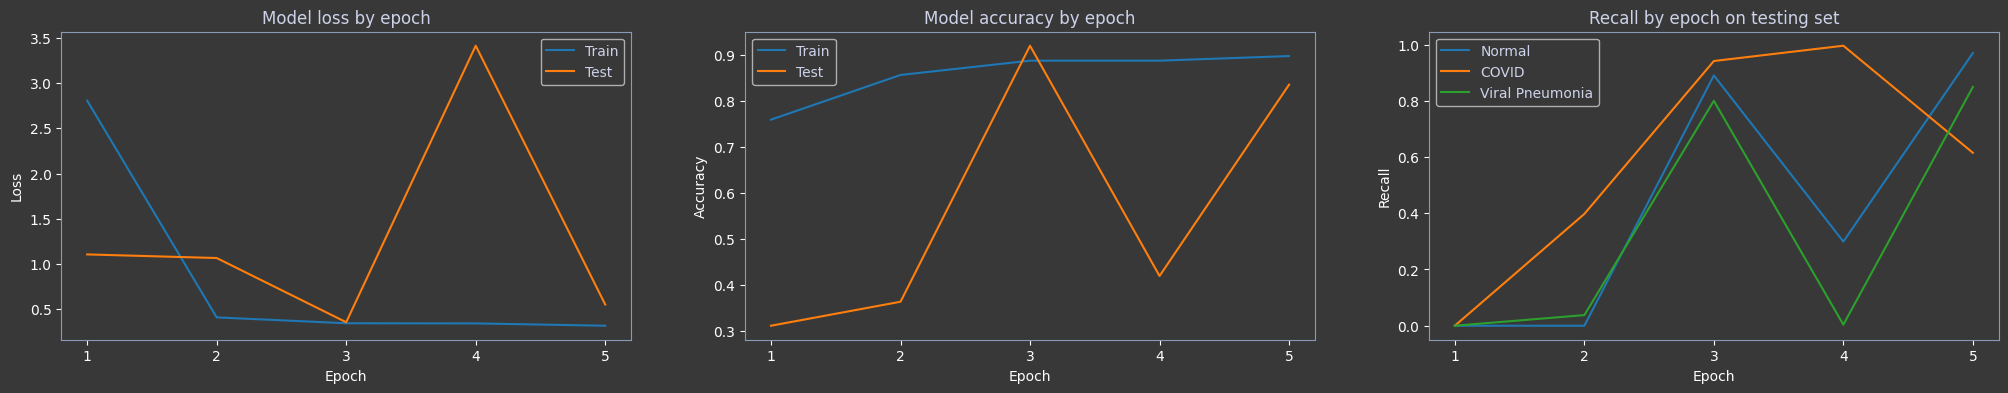

In [ ]:
#@title
plt.figure(figsize=(25,4))

plt.subplot(131)
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Test")
plt.title('Model loss by epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.legend()

plt.subplot(132)
plt.plot(history.history['accuracy'], label="Train")
plt.plot(history.history['val_accuracy'], label="Test")
plt.title('Model accuracy by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.legend()

plt.subplot(133)
plt.plot(history.history['val_recall_norm'], label="Normal")
plt.plot(history.history['val_recall_COV'], label="COVID")
plt.plot(history.history['val_recall_VP'], label="Viral Pneumonia")
plt.title('Recall by epoch on testing set')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.legend();

In [ ]:
#@title
# Prediction de l'échantillon de test
test_pred = classifier.predict(test_set)

# repasser en labels de classes
y_test_class = np.array(data_test['class'].astype(int))
test_pred_class = test_pred.argmax(axis=1)

classes = range(0,n_class)
labels_class = ["Normal", "COVID", "Viral Pneumonia"]

print(metrics.classification_report(y_test_class, test_pred_class, target_names=labels_class))

                 precision    recall  f1-score   support

         Normal       0.79      0.97      0.87       269
          COVID       0.99      0.66      0.79       240
Viral Pneumonia       0.80      0.86      0.83       269

       accuracy                           0.84       778
      macro avg       0.86      0.83      0.83       778
   weighted avg       0.86      0.84      0.83       778



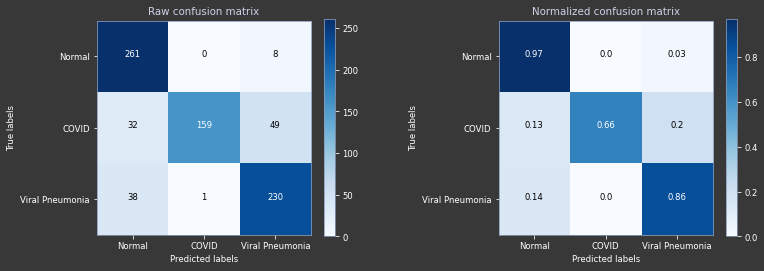

In [ ]:
#@title
plt.rcParams['font.size'] = 8.5
#### Figures
plt.figure(figsize = (12,4))
plt.subplots_adjust(wspace=0.5)   # add space between plots

### confusion matrix
raw_cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
norm_cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class, normalize="true")

#### RAW confusion matrix
plt.subplot(121)
plt.imshow(raw_cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Raw confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels_class)
plt.yticks(tick_marks, labels_class)

for i, j in itertools.product(range(raw_cnf_matrix.shape[0]), range(raw_cnf_matrix.shape[1])):
    plt.text(j, i, raw_cnf_matrix[i, j].round(2),
             horizontalalignment = "center",
             color = "white" if raw_cnf_matrix[i, j] > ( raw_cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted labels');



#### NORMALIZED confusion matrix
plt.subplot(122)
plt.imshow(norm_cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Normalized confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels_class)
plt.yticks(tick_marks, labels_class)

for i, j in itertools.product(range(norm_cnf_matrix.shape[0]), range(norm_cnf_matrix.shape[1])):
    plt.text(j, i, norm_cnf_matrix[i, j].round(2),
             horizontalalignment = "center",
             color = "white" if norm_cnf_matrix[i, j] > ( norm_cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted labels');

plt.rcParams['font.size'] = 10.0

For our class of interest (COVID), the recall score is pretty good (95%). This is the most relevant metric to us because we absolutely do not want to misdiagnose true COVID patients as falsely healthy or with a "simple" viral pneumonia. Because that would mean that true COVID cases would slip through the specific medical care, quarantine protocols etc, and would propagate the disease. On the contrary, we are willing to misdiagnose true healthy or viral pneumonia patients as false COVID, "better safe than sorry".

<br>

## Model optimization

### Callbacks

We optimize the model using by minimizing the loss on the validation dataset.
We fit over 20 epochs and:
1. the fitting stops when the validation set loss hasn't been minimized for more than 5 epochs
1. the learning rate is reduced by a factor 10 when the loss of the validation set reached a plateau for 2 epochs.

<br>

---

<br>

<font color="IndianRed">**UPDATE:**
* `early_stopping` : added `restore_best_weights=True` (default = `False`), no need to load model or weights :
>_Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used._ [--Keras doc](https://keras.io/api/callbacks/early_stopping/)</font>


<br>

---

<br>

<font color="Teal">**Technical note:** `.fit_generator` is deprecated in this version and was updated with `.fit`.</font>

In [ ]:
## callbacks
# early stopping : stopper l'entraînement lorsque val_loss est minimisé
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=5, 
                                        mode="min", 
                                        verbose=2,
                                        restore_best_weights=True)

# reduce learning rate when reaching val_loss plateau (default factor = 0.1)
lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose = 2, mode = "min")

## entraînement
epochs = 20
# fit_generator is deprecated
training_history = classifier.fit(training_set,    # previously generator=training_set
                                  epochs=epochs, 
                                  steps_per_epoch=len(training_set._filepaths) // batch_size,
                                  workers = -1, 
                                  validation_data=test_set, 
                                  validation_steps=len(test_set._filepaths) // batch_size,
                                  callbacks = [early_stopping_callback, lr_plateau],
                                  verbose=1)

Epoch 1/20
194/194 [==============================] - 69s 354ms/step - loss: 0.3167 - accuracy: 0.8981 - recall_norm: 0.9070 - recall_COV: 0.9005 - recall_VP: 0.8527 - val_loss: 2.3263 - val_accuracy: 0.5951 - val_recall_norm: 1.0000 - val_recall_COV: 0.7573 - val_recall_VP: 0.0377
Epoch 2/20
194/194 [==============================] - 67s 346ms/step - loss: 0.2901 - accuracy: 0.8968 - recall_norm: 0.9034 - recall_COV: 0.9172 - recall_VP: 0.8479 - val_loss: 0.4171 - val_accuracy: 0.8294 - val_recall_norm: 0.9848 - val_recall_COV: 0.8828 - val_recall_VP: 0.5887
Epoch 3/20
194/194 [==============================] - 67s 343ms/step - loss: 0.2903 - accuracy: 0.9017 - recall_norm: 0.8958 - recall_COV: 0.9279 - recall_VP: 0.8570 - val_loss: 0.9366 - val_accuracy: 0.7018 - val_recall_norm: 0.9962 - val_recall_COV: 0.9582 - val_recall_VP: 0.1623
Epoch 4/20
194/194 [==============================] - 67s 343ms/step - loss: 0.2972 - accuracy: 0.9017 - recall_norm: 0.9061 - recall_COV: 0.9321 - rec

The best saved model was at epoch 19


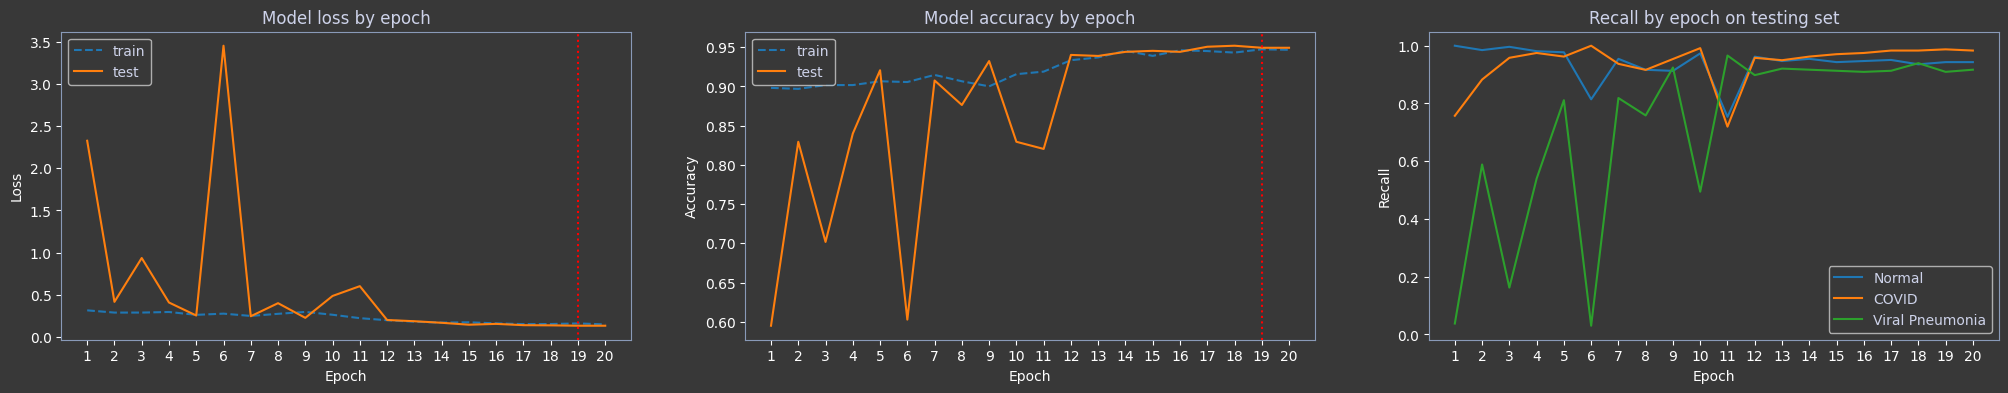

In [ ]:
#@title
n_epochs = len(training_history.history["val_loss"])        # total of epochs before early stopping
n_epochs_best = np.argmin(training_history.history['val_loss'])    # best epoch based on val_loss (early_stopping), starting at epoch 1 (not 0)
print("The best saved model was at epoch", n_epochs_best + 1)

plt.figure(figsize=(25,4))
plt.subplot(131)
plt.plot(training_history.history['loss'], "--")
plt.plot(training_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.axvline(x = n_epochs_best, color = "r", linestyle=":")
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(132)
plt.plot(training_history.history['accuracy'], "--")
plt.plot(training_history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.axvline(x = n_epochs_best, color = "r", linestyle=":")
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(133)
plt.plot(training_history.history['val_recall_norm'], label="Normal")
plt.plot(training_history.history['val_recall_COV'], label="COVID")
plt.plot(training_history.history['val_recall_VP'], label="Viral Pneumonia")
plt.title('Recall by epoch on testing set')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.legend();

### Making predictions

<font color="IndianRed">There is no need to recreate the model and load the saved weights, as `restore_best_weights=True` in the early stopping callback : the weights corresponding to the best (minimized) `val_loss` are stored in the model.</font>

We evaluate the model twice :
* the Keras way (`classifier.evaluate`)
* the Scikit-learn way:
  + predict with Keras (`classifier.predict`)
  + compute classification report and confusion matrix with scikit

In [ ]:
# evaluate the model
train_loss, train_acc, train_recall_norm, train_recall_COV, train_recall_VP = classifier.evaluate(training_set, verbose=0)
test_loss, test_acc, test_recall_norm, test_recall_COV, test_recall_VP = classifier.evaluate(test_set, verbose=0)

In [ ]:
#@title
print('Train accuracy: %.2f%%,\t\t\tTest accuracy: %.2f%%' % (train_acc*100, test_acc*100))
print('Train recall Normal: %.2f%%,\t\tTest recall Normal: %.2f%%' % (train_recall_norm*100, test_recall_norm*100))
print('Train recall COVID: %.2f%%,\t\tTest recall COVID: %.2f%%' % (train_recall_COV*100, test_recall_COV*100))
print('Train recall Viral Pneumonia: %.2f%%,\tTest recall Viral Pneumonia: %.2f%%' % (train_recall_VP*100, test_recall_VP*100))

Train accuracy: 94.98%,			Test accuracy: 94.99%
Train recall Normal: 94.22%,		Test recall Normal: 94.42%
Train recall COVID: 97.60%,		Test recall COVID: 98.33%
Train recall Viral Pneumonia: 92.57%,	Test recall Viral Pneumonia: 91.82%


In [ ]:
# Prediction de l'échantillon de test
test_pred = classifier.predict(test_set)

# repasser en labels de classes
y_test_class = np.array(data_test['class'].astype(int))
test_pred_class = test_pred.argmax(axis=1)

classes = range(0,n_class)
labels_class = ["Normal", "COVID", "Viral Pneumonia"]

print(metrics.classification_report(y_test_class, test_pred_class, target_names=labels_class))

                 precision    recall  f1-score   support

         Normal       0.92      0.95      0.93       269
          COVID       1.00      0.98      0.99       240
Viral Pneumonia       0.94      0.92      0.93       269

       accuracy                           0.95       778
      macro avg       0.95      0.95      0.95       778
   weighted avg       0.95      0.95      0.95       778



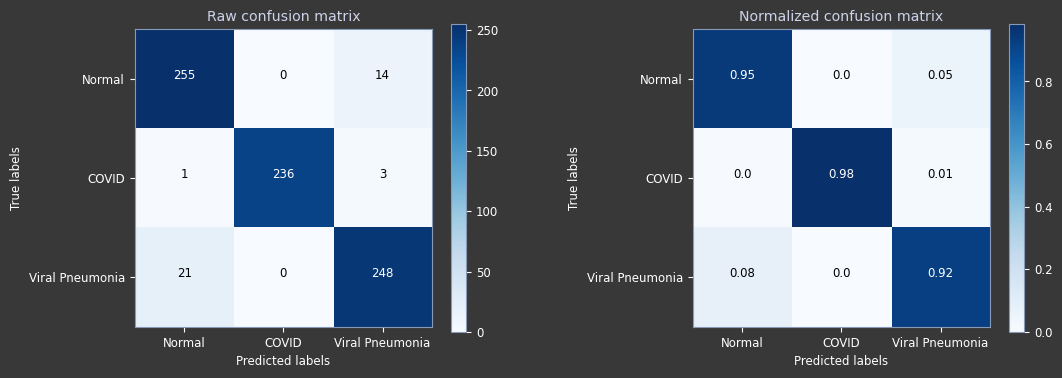

In [ ]:
#@title
plt.rcParams['font.size'] = 8.5

#### Figures
plt.figure(figsize = (12,4))
plt.subplots_adjust(wspace=0.5)   # add space between plots

### confusion matrix
raw_cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
norm_cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class, normalize="true")

#### RAW confusion matrix
plt.subplot(121)
plt.imshow(raw_cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Raw confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels_class)
plt.yticks(tick_marks, labels_class)

for i, j in itertools.product(range(raw_cnf_matrix.shape[0]), range(raw_cnf_matrix.shape[1])):
    plt.text(j, i, raw_cnf_matrix[i, j].round(2),
             horizontalalignment = "center",
             color = "white" if raw_cnf_matrix[i, j] > ( raw_cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted labels');



#### NORMALIZED confusion matrix
plt.subplot(122)
plt.imshow(norm_cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Normalized confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels_class)
plt.yticks(tick_marks, labels_class)

for i, j in itertools.product(range(norm_cnf_matrix.shape[0]), range(norm_cnf_matrix.shape[1])):
    plt.text(j, i, norm_cnf_matrix[i, j].round(2),
             horizontalalignment = "center",
             color = "white" if norm_cnf_matrix[i, j] > ( norm_cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted labels');
plt.rcParams['font.size'] = 10.0

Optimization improved overall accuracy, and recall was improved for all three classes. However, we can aim for better recall, and we will try this by using a deeper pre-trained model _via_ transfer learning.

# Modelisation : transfer learning - DenseNet201

Using the same split data and image generators, we try to optimize our modelization _via_ transfer learning.

We use a variant of the DenseNet architecture.

<img src="https://i.imgur.com/7Le03yx.jpeg"><br>
<font size="2"><b><u>Architecture of DenseNet-121.</b></u>
<b>Dx:</b> Dense Block x. <b>Tx:</b> Transition Block x. <b>DLx:</b> Dense Layer x.

From <a href=https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a>Understanding and visualizing DenseNets</a>, by Pablo Ruiz.
</font>

## Network design

We use the DenseNet201 model<sup>1, 2</sup> with its weights set to the [_ImageNet_](http://www.image-net.org/) dataset and without the fully connected layers (`include_top = False`) that we will add ourselves.

We did several runs, and found that in addition to unfreezing the dense layers, unfreezing the last convolutional block of DenseNet201 gave slightly better results. This could be due to the fact that although DenseNet is well trained on various images (via the imagenet weights we are using), there are some useful features specific to our dataset that it can find by fine tuning this last convolutional block.

<br>

---

1: Densely Connected Convolutional Networks, Huang _et al._, 2018, [arXiv](https://arxiv.org/pdf/1608.06993.pdf)

2: [Understanding and visualizing DenseNets](https://towardsdatascience.com/understanding-and-visualizing-densenets-7f688092391a), Pablo Ruiz, 2018

## Image generator

We use the same generators as in the first iteration, but the `color_mode` is switched to `rgb`, `batch_size` is set to `32`.

In [ ]:
### Image generator
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                          rotation_range=10,
                                          width_shift_range=.1,
                                          height_shift_range=.1,
                                          # zoom_range=.1,
                                          # brightness_range=[0.2,1.0],
                                          horizontal_flip=True,
                                          vertical_flip=True)

test_data_generator = ImageDataGenerator(rescale = 1./255)

### Iterator
batch_size = 32
n_class = len(df["class"].unique())

# pour éviter l'erreur If class_mode="sparse", y_col="class" column values must be strings.
# il faut convertir data["class"] en str()

pd.options.mode.chained_assignment = None   # suppress Pandas SettingWithCopyWarning
data_train["class"] = data_train["class"].astype(str)
data_test["class"] = data_test["class"].astype(str)
pd.options.mode.chained_assignment = "warn"   # set default back

training_set = train_data_generator.flow_from_dataframe(dataframe=data_train,      # df contenant les infos
                    x_col="filepaths",         # col du df contenant les filepaths
                    y_col=["Normal", "COVID", "ViralPneumonia"],             # cols du df contenant les one hot encoded classes
                    class_mode="raw",          # pour prendre les 4 colonnes
                    target_size=(224,224),     # taille des images à redimensionner
                    color_mode="rgb",          # images en couleurs                                                        
                    batch_size=batch_size)

test_set = test_data_generator.flow_from_dataframe(dataframe=data_test,         # df contenant les infos
                    x_col="filepaths",           # col du df contenant les filepaths
                    y_col=["Normal", "COVID", "ViralPneumonia"],             # cols du df contenant les one hot encoded classes
                    class_mode="raw",           # pour prendre les 4 colonnes
                    target_size=(224,224),      # taille des images à redimensionner
                    color_mode="rgb",           # images en couleurs                                                        
                    shuffle = False,            # nécessaire pour que les prédictions soient dans le même ordre que les vraies valeurs
                    batch_size=batch_size)

Found 3108 validated image filenames.
Found 778 validated image filenames.


In [ ]:
model=DenseNet201(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 

model_output = model.output

model_output = GlobalAveragePooling2D()(model_output)
model_output = BatchNormalization()(model_output)
model_output = Dropout(rate = 0.2)(model_output)
model_output = Dense(units = 1024, activation = 'relu')(model_output) 
model_output = Dense(units = 512, activation = 'relu')(model_output) 
model_output = BatchNormalization()(model_output)
model_output = Dropout(rate = 0.2)(model_output)

preds = Dense(units = n_class, activation = 'softmax')(model_output) # FC-layer

model = Model(inputs = model.input, outputs = preds)

dense_layers = 8    # number of dense layers
last_block = 9      # number of layers in block 32 (last CNN block)
layers_to_unfreeze = dense_layers + last_block

# Freezing DenseNet201 layers' weights
for layer in model.layers[:-layers_to_unfreeze]:
    layer.trainable=False
    
for layer in model.layers[-layers_to_unfreeze:]:
    layer.trainable=True

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

### Compilation

Adding recall metrics for each **class**.

In [ ]:
## compilation
model.compile(optimizer = "adam", 
                   loss = "categorical_crossentropy",                   
                   metrics = ["accuracy", 
                              Recall(class_id=0, name="recall_norm"),
                              Recall(class_id=1, name="recall_COV"),
                              Recall(class_id=2, name="recall_VP")])

### Callbacks

Adding callbacks:

* ReduceLROnPlateau: based on `val_loss`. We reduce learning rate when reaching val_loss plateau (using default factor = 0.1)
* EarlyStopping: based on `val_loss`. We stop the training when the loss of validation dataset hasn't been minimized for 10 epochs, and restore the best weights to the model.
* ModelCheckpoint: based on `val_loss`. We save the full model and its weights as a .h5 file

In [ ]:
## callbacks
# early stopping : stopper l'entraînement lorsque val_loss est minimisé
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience=10, 
                                        verbose=2,
                                        mode="min", 
                                        restore_best_weights=True)

# save best model (with minimum val_loss)
timestr = time.strftime("%Y-%m-%d_%H-%M-%S")    # store the time string of the execution of this cell (to differentiate between runs)
filepath = 'best_DenseNet201_Unfreezed' + timestr + '.h5'     # use it in the filename

checkpoint_callback = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# reduce learning rate when reaching val_loss plateau (default factor = 0.1)
lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience = 3, verbose = 2, mode = "min")

### Fitting

We fit over 50 epochs.

In [ ]:
epochs = 50

## fitting
train_history = model.fit(training_set,
                             epochs=epochs, 
                             steps_per_epoch=len(training_set._filepaths) // batch_size,
                             workers = -1, 
                             validation_data=test_set, 
                             validation_steps=len(test_set._filepaths) // batch_size,
                             callbacks = [early_stopping_callback, lr_plateau, checkpoint_callback],
                             verbose=1)

Epoch 1/50
97/97 [==============================] - 101s 930ms/step - loss: 0.4283 - accuracy: 0.8742 - recall_norm: 0.8656 - recall_COV: 0.9106 - recall_VP: 0.8197 - val_loss: 0.2420 - val_accuracy: 0.9180 - val_recall_norm: 0.8788 - val_recall_COV: 0.8828 - val_recall_VP: 0.9736

Epoch 00001: val_loss improved from inf to 0.24197, saving model to best_DenseNet201_Unfreezed2021-02-25_21-49-09.h5
Epoch 2/50
97/97 [==============================] - 86s 892ms/step - loss: 0.1716 - accuracy: 0.9423 - recall_norm: 0.9456 - recall_COV: 0.9659 - recall_VP: 0.9157 - val_loss: 0.1712 - val_accuracy: 0.9323 - val_recall_norm: 0.9280 - val_recall_COV: 0.9038 - val_recall_VP: 0.9509

Epoch 00002: val_loss improved from 0.24197 to 0.17125, saving model to best_DenseNet201_Unfreezed2021-02-25_21-49-09.h5
Epoch 3/50
97/97 [==============================] - 85s 873ms/step - loss: 0.1531 - accuracy: 0.9474 - recall_norm: 0.9464 - recall_COV: 0.9770 - recall_VP: 0.9205 - val_loss: 0.1549 - val_accuracy

The best saved model was at epoch 9


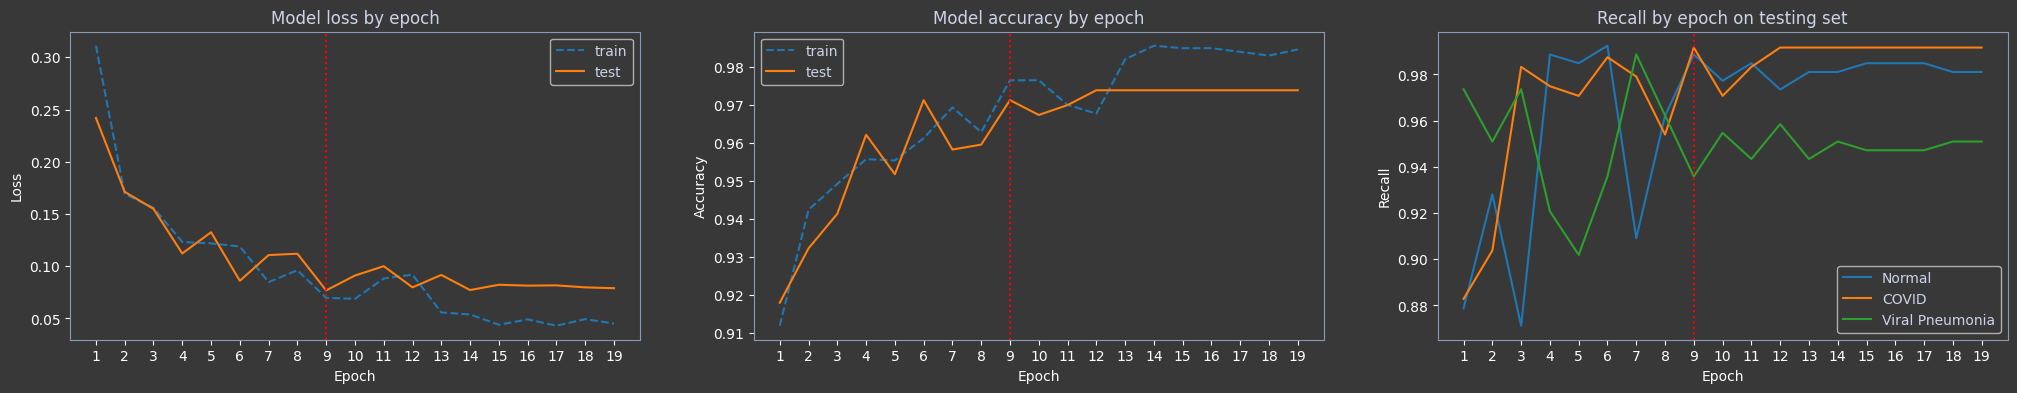

In [ ]:
#@title
n_epochs = len(train_history.history["val_loss"])        # total of epochs before early stopping
n_epochs_best = np.argmin(train_history.history['val_loss'])    # best epoch based on val_loss (early_stopping), starting at epoch 1 (not 0)
print("The best saved model was at epoch", n_epochs_best + 1)

plt.figure(figsize=(25,4))
plt.subplot(131)
plt.plot(train_history.history['loss'], "--")
plt.plot(train_history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.axvline(x = n_epochs_best, color = "r", linestyle=":")
plt.legend(['train', 'test'], loc='upper right')

plt.subplot(132)
plt.plot(train_history.history['accuracy'], "--")
plt.plot(train_history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.axvline(x = n_epochs_best, color = "r", linestyle=":")
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(133)
plt.plot(train_history.history['val_recall_norm'], label="Normal")
plt.plot(train_history.history['val_recall_COV'], label="COVID")
plt.plot(train_history.history['val_recall_VP'], label="Viral Pneumonia")
plt.title('Recall by epoch on testing set')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.xticks(np.arange(n_epochs), np.arange(1, n_epochs+1))
plt.axvline(x = n_epochs_best, color = "r", linestyle=":")
plt.legend();

## Model evaluation

We evaluate the model twice, focusing on recall :
* the Keras way (`classifier.evaluate`)
* the Scikit-learn way:
  + predict with Keras (`classifier.predict`)
  + compute classification report and confusion matrix with scikit

In [ ]:
# evaluate the model
train_loss, train_acc, train_recall_norm, train_recall_COV, train_recall_VP = model.evaluate(training_set, verbose=0)
test_loss, test_acc, test_recall_norm, test_recall_COV, test_recall_VP = model.evaluate(test_set, verbose=0)

In [ ]:
#@title
print('Train accuracy: %.2f%%,\t\t\tTest accuracy: %.2f%%' % (train_acc*100, test_acc*100))
print('Train recall Normal: %.2f%%,\t\tTest recall Normal: %.2f%%' % (train_recall_norm*100, test_recall_norm*100))
print('Train recall COVID: %.2f%%,\t\tTest recall COVID: %.2f%%' % (train_recall_COV*100, test_recall_COV*100))
print('Train recall Viral Pneumonia: %.2f%%,\tTest recall Viral Pneumonia: %.2f%%' % (train_recall_VP*100, test_recall_VP*100))

Train accuracy: 98.58%,			Test accuracy: 97.17%
Train recall Normal: 97.95%,		Test recall Normal: 98.88%
Train recall COVID: 99.58%,		Test recall COVID: 99.17%
Train recall Viral Pneumonia: 98.33%,	Test recall Viral Pneumonia: 93.68%


In [ ]:
#@title
# Prediction de l'échantillon de test
test_pred = model.predict(test_set)

# repasser en labels de classes
y_test_class = np.array(data_test['class'].astype(int))
test_pred_class = test_pred.argmax(axis=1)

print(metrics.classification_report(y_test_class, test_pred_class, target_names=labels_class))

                 precision    recall  f1-score   support

         Normal       0.94      0.99      0.96       269
          COVID       1.00      0.99      1.00       240
Viral Pneumonia       0.98      0.94      0.96       269

       accuracy                           0.97       778
      macro avg       0.97      0.97      0.97       778
   weighted avg       0.97      0.97      0.97       778



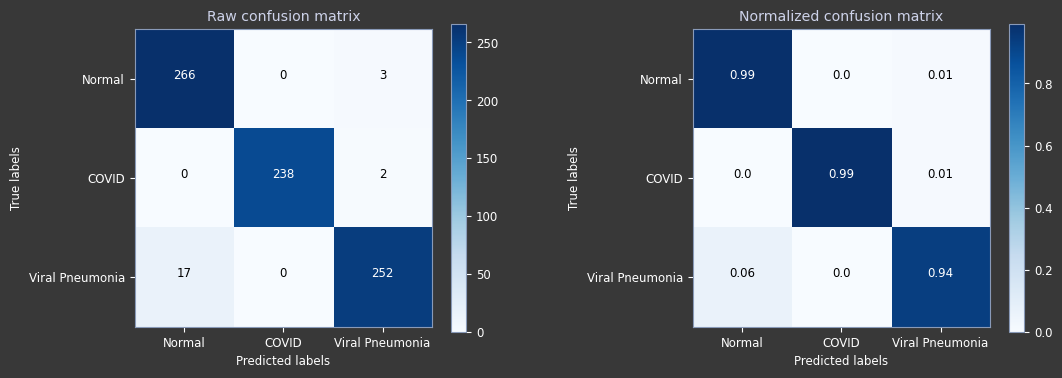

In [ ]:
#@title
plt.rcParams['font.size'] = 8.5

#### Figures
plt.figure(figsize = (12,4))
plt.subplots_adjust(wspace=0.5)   # add space between plots

### confusion matrix
raw_cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)
norm_cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class, normalize="true")

#### RAW confusion matrix
plt.subplot(121)
plt.imshow(raw_cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Raw confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels_class)
plt.yticks(tick_marks, labels_class)

for i, j in itertools.product(range(raw_cnf_matrix.shape[0]), range(raw_cnf_matrix.shape[1])):
    plt.text(j, i, raw_cnf_matrix[i, j].round(2),
             horizontalalignment = "center",
             color = "white" if raw_cnf_matrix[i, j] > ( raw_cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted labels');



#### NORMALIZED confusion matrix
plt.subplot(122)
plt.imshow(norm_cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Normalized confusion matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, labels_class)
plt.yticks(tick_marks, labels_class)

for i, j in itertools.product(range(norm_cnf_matrix.shape[0]), range(norm_cnf_matrix.shape[1])):
    plt.text(j, i, norm_cnf_matrix[i, j].round(2),
             horizontalalignment = "center",
             color = "white" if norm_cnf_matrix[i, j] > ( norm_cnf_matrix.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted labels');
plt.rcParams['font.size'] = 10.0

The recall is more satisfying, even though in another run of this code we managed to obtain a perfect recall for the COVID class. We didn't have time to find which images were misclassified and why, but we plan to present this next week.

### Save model to Google Drive

In [ ]:
### Save full model to Google Drive

# find file ending with .h5
for file in os.listdir("."):
    if file.endswith(".h5"):
        h5_path = os.path.join("/content/", file)
        model_name = file

# copy from Colab to Drive
!cp {h5_path} "./gdrive/My Drive/pyCOVID/model/{model_name}"

# Bonus : image segmentation

<font color="IndianRed">Running all these cells in a single notebook messes up matplotlib : some images are zoomed even though they run perfectly in [their notebook](https://colab.research.google.com/drive/1MGaUsNOpyTf2apTvGNHPgzMyprTG6wSY?usp=sharing)...</font>

We wanted to do some image segmentation in order to isolate the lungs and run our model on these segmented images. This would theoretically decrease the classification errors due to interferences from other parts of the X-ray.

Below is how far we managed to get in a couple of days.

## Implementing threshold

Otsu's binarization<sup>1</sup> (named after Nobuyuki Otsu<sup>2</sup>) searches for the threshold that minimizes the intra-class variance, defined as a weighted sum of variances of the two classes.

<br>

---

<br>

1. : [OpenCV doc](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#otsus-binarization) on Otsu's binarization.
1. : Nobuyuki Otsu (1979). "A threshold selection method from gray-level histograms". IEEE Trans. Sys. Man. Cyber. 9 (1): 62–66. [doi:10.1109/TSMC.1979.4310076](doi:10.1109/TSMC.1979.4310076).

## Load image

We randomly pick one image from each class and try to segment it.

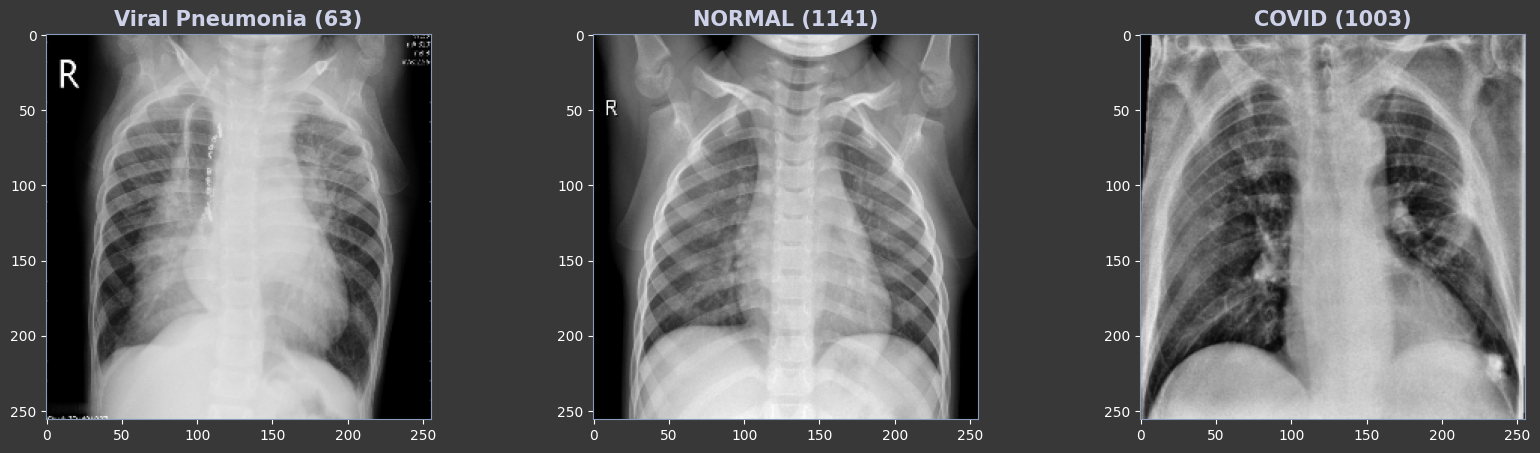

In [ ]:
#### Display a random image for each type
import os.path

datapath = "./data/"    # Google Colab local

types = ["Viral Pneumonia", "NORMAL", "COVID"]
num_files = {}   # number of files in each folder/type
rand_n = {}      # store random number for each type
img_paths = []   # filepaths to selected random img
imgs = []        # corresponding img arrays

for t in types:
    # number of files in each folder/type
    num_files[t] = len([f for f in os.listdir(datapath + t + "/")if os.path.isfile(os.path.join(datapath + t + "/", f))])
    
    # choose random file number within range of each type and generate filepath
    rand_n[t] = str(np.random.randint(1, num_files[t], 1)[0])
    img_paths.append(datapath + t + "/" + t + " (" + rand_n[t] + ").png")

# read imgs in list
for i in img_paths:
    orig = cv2.imread(i, cv2.IMREAD_COLOR)     # read img
    resized = cv2.resize(orig, dsize= (256,256))   # resize it to 256 x 256
    imgs.append(resized)

# display images
fig = plt.figure(figsize=(20, 5))

for i, t in zip(range(3), types):
    ax = fig.add_subplot(131 + i)
    ax.imshow(imgs[i], cmap="gray")
    ax.set_title(t + " (" + rand_n[t] + ")",
                  fontdict={'fontsize': 15, 
                       'fontweight': 'bold'})
#     plt.xticks([])
#     plt.yticks([])

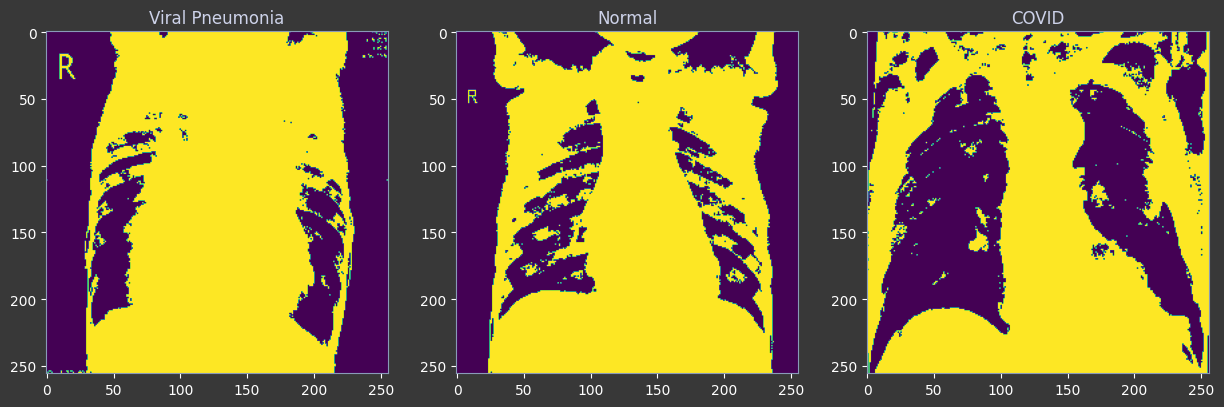

In [ ]:
#@title
# Viral pneumonia case
img_vp = imgs[0]

hsv_vp = cv2.cvtColor(img_vp, cv2.COLOR_BGR2HSV)
h_vp,s_vp,v_vp = cv2.split(hsv_vp)
ret_h_vp, th_h_vp = cv2.threshold(h_vp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_s_vp, th_s_vp = cv2.threshold(s_vp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_v_vp, th_v_vp = cv2.threshold(v_vp,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

img_vp_thresh = th_h_vp+th_s_vp+th_v_vp

# Normal case
img_normal = imgs[1]

hsv_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2HSV)
h_normal,s_normal,v_normal = cv2.split(hsv_normal)
ret_h_normal, th_h_normal = cv2.threshold(h_normal,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_s_normal, th_s_normal = cv2.threshold(s_normal,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_v_normal, th_v_normal = cv2.threshold(v_normal,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

img_normal_thresh = th_h_normal+th_s_normal+th_v_normal

# Covid case
img_covid = imgs[2]

hsv_covid = cv2.cvtColor(img_covid, cv2.COLOR_BGR2HSV)
h_covid,s_covid,v_covid = cv2.split(hsv_covid)
ret_h_covid, th_h_covid = cv2.threshold(h_covid,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_s_covid, th_s_covid = cv2.threshold(s_covid,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret_v_covid, th_v_covid = cv2.threshold(v_covid,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

img_covid_thresh = th_h_covid+th_s_covid+th_v_covid


plt.figure(figsize = (15,5))
plt.subplot(1,3,1)
plt.imshow(img_vp_thresh)
plt.title('Viral Pneumonia');

plt.subplot(1,3,2)
plt.imshow(img_normal_thresh)
plt.title('Normal');

plt.subplot(1,3,3)
plt.imshow(img_covid_thresh)
plt.title('COVID');

In [ ]:
#@title
# Viral Pneumonia
km_vp = np.array(img_vp_thresh, dtype="uint8")
k_masks_vp = cv2.bitwise_not(km_vp)   # inverser le masque

k_mask_imgs_vp = cv2.bitwise_and(img_vp, img_vp, mask=k_masks_vp)  # appliquer le masque à l'image

# Normal
km_normal = np.array(img_normal_thresh, dtype="uint8")
k_masks_normal = cv2.bitwise_not(km_normal)   # inverser le masque

k_mask_imgs_normal = cv2.bitwise_and(img_normal, img_normal, mask=k_masks_normal)  # appliquer le masque à l'image

# COVID
km_covid = np.array(img_covid_thresh, dtype="uint8")
k_masks_covid = cv2.bitwise_not(km_covid)   # inverser le masque

k_mask_imgs_covid = cv2.bitwise_and(img_covid, img_covid, mask=k_masks_covid)  # appliquer le masque à l'image

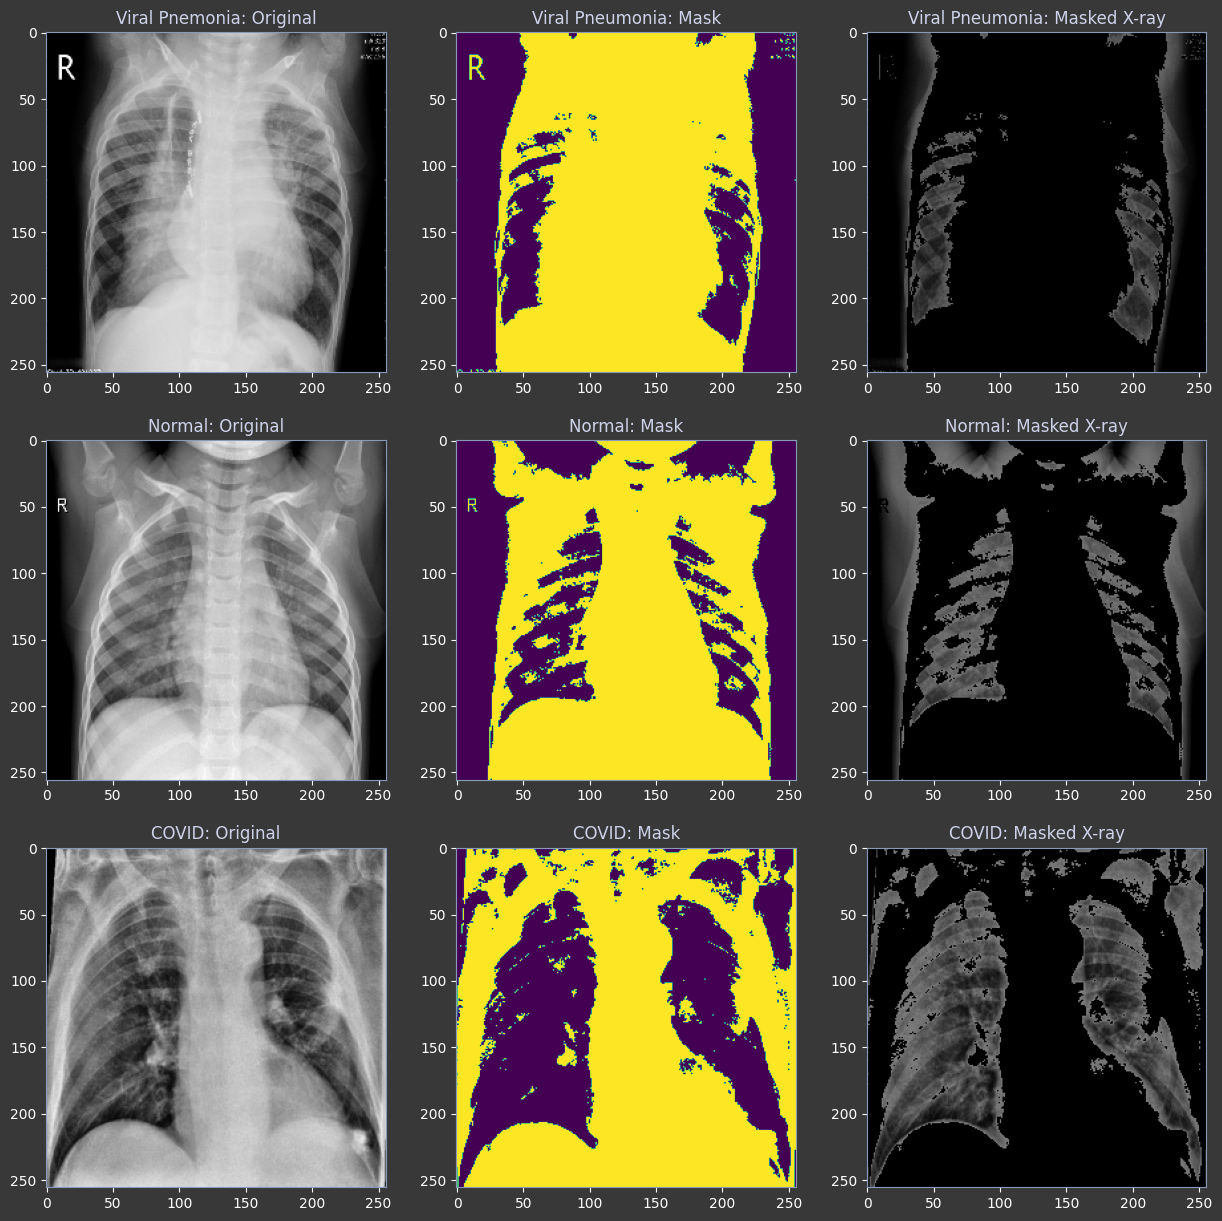

In [ ]:
#@title
plt.figure(figsize = (15,15))

# Viral Pneumonia
plt.subplot(3,3,1)
plt.imshow(img_vp)
plt.title("Viral Pnemonia: Original");

plt.subplot(3,3,2)
plt.imshow(img_vp_thresh)
plt.title("Viral Pneumonia: Mask");

plt.subplot(3,3,3)
plt.imshow(k_mask_imgs_vp)
plt.title("Viral Pneumonia: Masked X-ray");

# Normal
plt.subplot(3,3,4)
plt.imshow(img_normal)
plt.title("Normal: Original");

plt.subplot(3,3,5)
plt.imshow(img_normal_thresh)
plt.title("Normal: Mask");

plt.subplot(3,3,6)
plt.imshow(k_mask_imgs_normal)
plt.title("Normal: Masked X-ray");

# COVID
plt.subplot(3,3,7)
plt.imshow(img_covid)
plt.title("COVID: Original");

plt.subplot(3,3,8)
plt.imshow(img_covid_thresh)
plt.title("COVID: Mask");

plt.subplot(3,3,9)
plt.imshow(k_mask_imgs_covid)
plt.title("COVID: Masked X-ray");

In [ ]:
#@title
# Viral Pneumonia

lungs_l_vp = []
masked_lungs_l_vp = []

lungs_vp = cv2.bitwise_not(k_masks_vp)   # inverser le masque

  # find surrounding torso from the threshold and make a mask
contours_vp, _ = cv2.findContours(lungs_vp,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
largest_contour_vp = max(contours_vp, key=cv2.contourArea)
mask_vp = np.zeros(lungs_vp.shape, np.uint8)
cv2.fillPoly(mask_vp, [largest_contour_vp], 255)
  # apply mask to threshold image to remove outside. this is our new mask
lungs_vp = ~lungs_vp
lungs_vp[(mask_vp == 0)] = 0 # <-- Larger than threshold value
  # apply closing to the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
#lungs_vp = cv2.morphologyEx(lungs_vp, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_DILATE, kernel)
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_DILATE, kernel)
#lungs_vp = cv2.morphologyEx(lungs_vp, cv2.MORPH_CLOSE, kernel)
lungs_vp = cv2.morphologyEx(lungs_vp, cv2.MORPH_CLOSE, kernel)
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_ERODE, kernel)

#lungs_l.append(lungs)    # store
lungs_l_vp = lungs_vp
  # apply mask to image
masked_lungs_vp = cv2.bitwise_and(img_vp, img_vp, mask=lungs_l_vp)  # appliquer le masque à l'image
#masked_lungs_l.append(masked_lungs)    # store
masked_lungs_l_vp = masked_lungs_vp


# Normal

lungs_l_normal = []
masked_lungs_l_normal = []

lungs_normal = cv2.bitwise_not(k_masks_normal)   # inverser le masque

  # find surrounding torso from the threshold and make a mask
contours_normal, _ = cv2.findContours(lungs_normal,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
largest_contour_normal = max(contours_normal, key=cv2.contourArea)
mask_normal = np.zeros(lungs_normal.shape, np.uint8)
cv2.fillPoly(mask_normal, [largest_contour_normal], 255)
  # apply mask to threshold image to remove outside. this is our new mask
lungs_normal = ~lungs_normal
lungs_normal[(mask_normal == 0)] = 0 # <-- Larger than threshold value
  # apply closing to the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
#lungs_normal = cv2.morphologyEx(lungs_normal, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_DILATE, kernel)
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_DILATE, kernel)
#lungs_normal = cv2.morphologyEx(lungs_normal, cv2.MORPH_CLOSE, kernel)
lungs_normal = cv2.morphologyEx(lungs_normal, cv2.MORPH_CLOSE, kernel)
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_ERODE, kernel)

#lungs_l.append(lungs)    # store
lungs_l_normal = lungs_normal
  # apply mask to image
masked_lungs_normal = cv2.bitwise_and(img_normal, img_normal, mask=lungs_l_normal)  # appliquer le masque à l'image
#masked_lungs_l.append(masked_lungs)    # store
masked_lungs_l_normal = masked_lungs_normal


# Covid

lungs_l_covid = []
masked_lungs_l_covid = []

lungs_covid = cv2.bitwise_not(k_masks_covid)   # inverser le masque

  # find surrounding torso from the threshold and make a mask
contours_covid, _ = cv2.findContours(lungs_covid,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
largest_contour_covid = max(contours_covid, key=cv2.contourArea)
mask_covid = np.zeros(lungs_covid.shape, np.uint8)
cv2.fillPoly(mask_covid, [largest_contour_covid], 255)
  # apply mask to threshold image to remove outside. this is our new mask
lungs_covid = ~lungs_covid
lungs_covid[(mask_covid == 0)] = 0 # <-- Larger than threshold value
  # apply closing to the mask
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
#lungs_covid = cv2.morphologyEx(lungs_covid, cv2.MORPH_OPEN, kernel)  # <- to remove speckles...
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_DILATE, kernel)
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_DILATE, kernel)
lungs_covid = cv2.morphologyEx(lungs_covid, cv2.MORPH_CLOSE, kernel)
#lungs_covid = cv2.morphologyEx(lungs_covid, cv2.MORPH_CLOSE, kernel)
#lungs = cv2.morphologyEx(lungs, cv2.MORPH_ERODE, kernel)

#lungs_l.append(lungs)    # store
lungs_l_covid = lungs_covid
  # apply mask to image
masked_lungs_covid = cv2.bitwise_and(img_covid, img_covid, mask=lungs_l_covid)  # appliquer le masque à l'image
#masked_lungs_l.append(masked_lungs)    # store
masked_lungs_l_covid = masked_lungs_covid

## Plot Figures with mask 



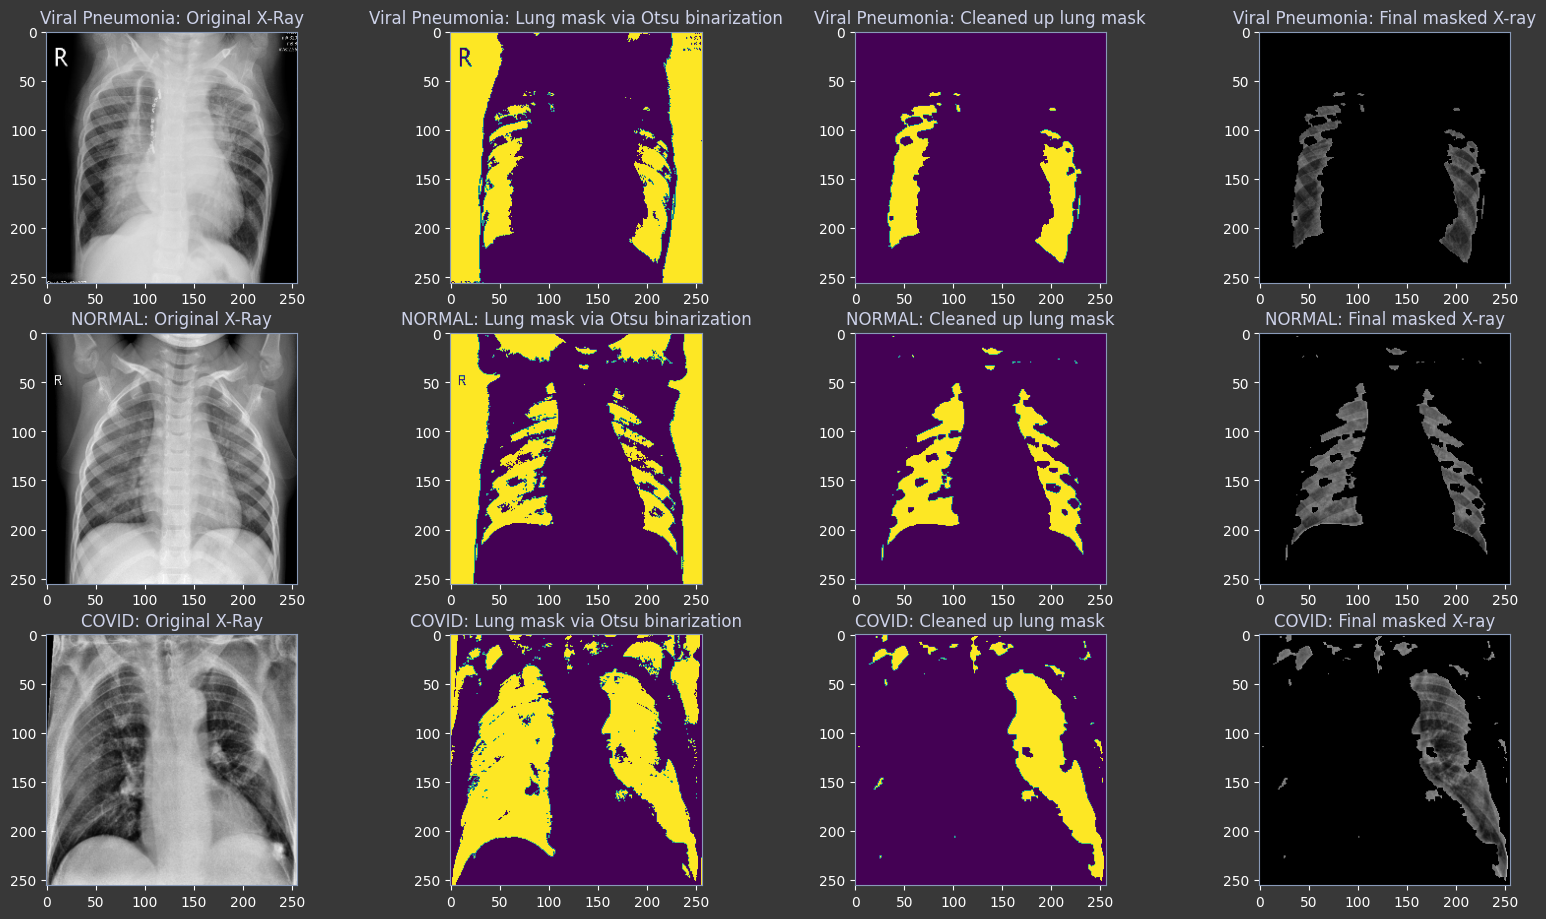

In [ ]:
#@title
############ Figure


plt.figure(figsize = (20, 15))

# Viral Pneumonia
plt.subplot(4,4,1)
plt.imshow(img_vp) 
plt.title("Viral Pneumonia: Original X-Ray");

plt.subplot(4,4,2)
plt.imshow(k_masks_vp) 
plt.title("Viral Pneumonia: Lung mask via Otsu binarization");

plt.subplot(4,4,3)
plt.imshow(lungs_l_vp)
plt.title("Viral Pneumonia: Cleaned up lung mask");

plt.subplot(4,4,4)
plt.imshow(masked_lungs_l_vp)
plt.title("Viral Pneumonia: Final masked X-ray");


# NORMAL
plt.subplot(4,4,5)
plt.imshow(img_normal) 
plt.title("NORMAL: Original X-Ray");

plt.subplot(4,4,6)
plt.imshow(k_masks_normal) 
plt.title("NORMAL: Lung mask via Otsu binarization");

plt.subplot(4,4,7)
plt.imshow(lungs_l_normal)
plt.title("NORMAL: Cleaned up lung mask");

plt.subplot(4,4,8)
plt.imshow(masked_lungs_l_normal)
plt.title("NORMAL: Final masked X-ray");


# COVID
plt.subplot(4,4,9)
plt.imshow(img_covid) 
plt.title("COVID: Original X-Ray");

plt.subplot(4,4,10)
plt.imshow(k_masks_covid) 
plt.title("COVID: Lung mask via Otsu binarization");

plt.subplot(4,4,11)
plt.imshow(lungs_l_covid)
plt.title("COVID: Cleaned up lung mask");

plt.subplot(4,4,12)
plt.imshow(masked_lungs_l_covid)
plt.title("COVID: Final masked X-ray");

We note that it's a challenge to find the right parameters in order to hightlights lungs in all the case. 
Perhaps, a good way to select lungs areas is to define closed contours (polygon) and filter polygons close to borders 